# Notebook for OPRM and SRM measurement comparison 

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pmagpy.pmag as pmag
import pmagpy.ipmag as ipmag
import pmagpy.pmagplotlib as pmagplotlib
import matplotlib
import matplotlib.colors as colors
import seaborn as sns
import os
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [128]:
figsize = (6,6)

def read_OPRM_file(path):
    DF = pd.read_csv(path, header = 4, index_col=None)
    DF['step'] = DF['DEMAG']
    DF['dec'] = pmag.cart2dir(DF[['X','Y','Z']].to_numpy()).T[0]
    DF['inc'] = pmag.cart2dir(DF[['X','Y','Z']]).T[1]
    DF['Ms'] = DF['M']
    DF['blank']=""
    DF['quality'] = 'g'
    
    return DF
        
def read_SRM_file(path):
    data = open(path)
    data_lines = data.readlines()

    DF = pd.DataFrame()
    step = []
    decs = []
    incs = []
    Ms = []
    for i in data_lines[2:]:
        step.append(i[3:7])
        decs.append(float(i[46:51]))
        incs.append(float(i[52:58]))
        Ms.append(float(i[31:39]))
    DF['step'] = step
    DF['dec'] = decs
    DF['inc'] = incs
    DF['Ms'] = Ms
    DF['blank']=""
    DF['quality'] = 'g'
    return DF
            
def plot_net(fignum=None):
#     if fignum != None:
#         plt.figure(num=fignum,figsize=figsize);
#         plt.clf()
    plt.axis("off")
    Dcirc = np.arange(0, 361.)
    Icirc = np.zeros(361, 'f')
    Xcirc, Ycirc = [], []
    for k in range(361):
        XY = pmag.dimap(Dcirc[k], Icirc[k])
        Xcirc.append(XY[0])
        Ycirc.append(XY[1])
    plt.plot(Xcirc, Ycirc, 'k');

# put on the tick marks
    Xsym, Ysym = [], []
    for I in range(10, 100, 10):
        XY = pmag.dimap(0., I)
        Xsym.append(XY[0])
        Ysym.append(XY[1])
    plt.plot(Xsym, Ysym, 'k+')
    Xsym, Ysym = [], []
    for I in range(10, 90, 10):
        XY = pmag.dimap(90., I)
        Xsym.append(XY[0])
        Ysym.append(XY[1])
    plt.plot(Xsym, Ysym, 'k+')
    Xsym, Ysym = [], []
    for I in range(10, 90, 10):
        XY = pmag.dimap(180., I)
        Xsym.append(XY[0])
        Ysym.append(XY[1])
    plt.plot(Xsym, Ysym, 'k+')
    Xsym, Ysym = [], []
    for I in range(10, 90, 10):
        XY = pmag.dimap(270., I)
        Xsym.append(XY[0])
        Ysym.append(XY[1])
    plt.plot(Xsym, Ysym, 'k+')
    for D in range(0, 360, 10):
        Xtick, Ytick = [], []
        for I in range(4):
            XY = pmag.dimap(D, I)
            Xtick.append(XY[0])
            Ytick.append(XY[1])
        plt.plot(Xtick, Ytick, 'k')
    plt.axis("equal")
    plt.axis((-1.05, 1.05, -1.05, 1.05))
    
def plot_eq(DIblock, specimen_name, fignum=0):
#     plt.figure(figsize = figsize);
    if len(DIblock) < 1:
        return
    # plt.clf()
#     if not isServer:
#         plt.figtext(.02, .01, version_num)
    plot_net(fignum=fignum);
    ipmag.plot_di(di_block=DIblock, color = 'blue');  # plot directions
    plt.axis("equal")
    plt.text(-1.1, 1.15, specimen_name)
#     plt.draw()
    
def plot_zij(datablock, angle, s, norm=True, fignum=1):
#     global globals
#     plt.figure(figsize = figsize);
#     plt.clf()
    amin, amax = 0., -100.
    if norm == 0:
        fact = 1.
    else:
        try:
            fact = (1./datablock[0][3])   # normalize to NRM=1
        except ZeroDivisionError:
            fact = 1.
    # convert datablock to DataFrame data with  dec,inc, int
    data = pd.DataFrame(datablock)
    if len(data.columns) == 5:
        data.columns = ['treat', 'dec', 'inc', 'int', 'quality']
    if len(data.columns) == 6:
        data.columns = ['treat', 'dec', 'inc', 'int', 'type', 'quality']
    elif len(data.columns) == 7:
        data.columns = ['treat', 'dec', 'inc', 'int', 'type', 'quality', 'y']
    #print (len(data.columns))
    data['int'] = data['int']*fact  # normalize
    data['dec'] = (data['dec']-angle) % 360  # adjust X axis angle
    gdata = data[data['quality'].str.contains('g')]
    bdata = data[data['quality'].str.contains('b')]
    forVDS = gdata[['dec', 'inc', 'int']].values
    gXYZ = pd.DataFrame(pmag.dir2cart(forVDS))
    gXYZ.columns = ['X', 'Y', 'Z']
    amax = np.maximum(gXYZ.X.max(), gXYZ.Z.max())
    amin = np.minimum(gXYZ.X.min(), gXYZ.Z.min())
    if amin > 0:
        amin = 0
    bXYZ = pmag.dir2cart(bdata[['dec', 'inc', 'int']].values).transpose()
# plotting stuff
    if angle != 0:
        tempstr = "\n Declination rotated by: " + str(angle) + '\n'
#     if globals != 0:
#         globals.text.insert(globals.END, tempstr)
#         globals.Zlist = gXYZ['x'].tolist()
#         globals.Zlisty = gXYZ['y'].tolist()
        globals.Zlistz = gXYZ['z'].tolist()
    if len(bXYZ) > 0:
        plt.scatter(bXYZ[0], bXYZ[1], marker='d', c='y', s=30)
        plt.scatter(bXYZ[0], bXYZ[2], marker='d', c='y', s=30)
    plt.plot(gXYZ['X'], gXYZ['Y'], 'ro')
    plt.plot(gXYZ['X'], gXYZ['Z'], 'ws', markeredgecolor='blue')
    plt.plot(gXYZ['X'], gXYZ['Y'], 'r-')
    plt.plot(gXYZ['X'], gXYZ['Z'], 'b-')
    for k in range(len(gXYZ)):
        plt.annotate(str(k), (gXYZ['X'][k], gXYZ['Z']
                              [k]), ha='left', va='bottom')
    if amin > 0 and amax >0:amin=0 # complete the line
    if amin < 0 and amax <0:amax=0 # complete the line
    xline = [amin, amax]
   # yline=[-amax,-amin]
    yline = [amax, amin]
    zline = [0, 0]
    plt.plot(xline, zline, 'k-')
    plt.plot(zline, xline, 'k-')
    if angle != 0:
        xlab = "X: rotated to Dec = " + '%7.1f' % (angle)
    if angle == 0:
        xlab = "X: rotated to Dec = " + '%7.1f' % (angle)
    plt.xlabel(xlab)
    plt.ylabel('Circles: Y; Squares: Z')
    tstring = s + ': NRM = ' + '%9.2e' % (datablock[0][3])
    plt.axis([amin, amax, amax, amin])
    plt.axis("equal")
    plt.title(tstring)

## holder OPRM

I did 10 measurement of the blank holder using only +Z measurement mode on the OPRM. The moment is quite consistent around E-7.

In [3]:
Holder_OPRM = read_OPRM_file('Holder.csv')
# Holder = Holder.drop(0)
# Holder = Holder.reset_index()
Holder_OPRM

,DEMAG,CD,CI,M,X,Y,Z,S/D,S/H,Orientation,Date&Time,Unnamed: 11,dec,inc
0,NRM,356.4,89.5,2.980000e-05,2.360000e-07,-1.470000e-08,2.980000e-05,0.00078,0,T_4MR_T+Z-Z,2-Jun,2021 15:23,356.435757,89.545378
1,NRM,185.0,-16.8,3.630000e-08,-3.460000e-08,-3.010000e-09,-1.050000e-08,0.01160,0,T_4MR_T+Z-Z,2-Jun,2021 15:27,184.971884,-16.821451
2,NRM,307.3,-79.5,1.710000e-07,1.880000e-08,-2.470000e-08,-1.680000e-07,0.29900,0,T_4MR_T+Z,2-Jun,2021 15:30,307.275982,-79.531716
3,NRM,281.8,-44.2,1.740000e-07,2.560000e-08,-1.230000e-07,-1.220000e-07,0.54100,0,T_4MR_T+Z,2-Jun,2021 15:31,281.757127,-44.158836
4,NRM,293.7,-62.7,2.030000e-07,3.750000e-08,-8.530000e-08,-1.810000e-07,0.43600,0,T_4MR_T+Z,2-Jun,2021 15:32,293.731484,-62.760522
5,NRM,257.2,-68.1,1.300000e-07,-1.070000e-08,-4.720000e-08,-1.210000e-07,0.40900,0,T_4MR_T+Z,2-Jun,2021 15:33,257.227218,-68.199560
6,NRM,295.9,-48.5,2.220000e-07,6.430000e-08,-1.330000e-07,-1.670000e-07,5.04000,0,T_4MR_T+Z,2-Jun,2021 15:34,295.801846,-48.504112
7,NRM,313.9,-56.0,1.890000e-07,7.350000e-08,-7.640000e-08,-1.570000e-07,1.93000,0,T_4MR_T+Z,2-Jun,2021 15:35,313.891681,-55.970588
8,NRM,240.5,-18.5,1.350000e-07,-6.280000e-08,-1.110000e-07,-4.290000e-08,0.94000,0,T_4MR_T+Z,2-Jun,2021 15:35,240.500304,-18.591999
9,NRM,292.3,-46.6,1.470000e-07,3.820000e-08,-9.310000e-08,-1.070000e-07,0.17800,0,T_4MR_T+Z,2-Jun,2021 15:36,292.308906,-46.756619


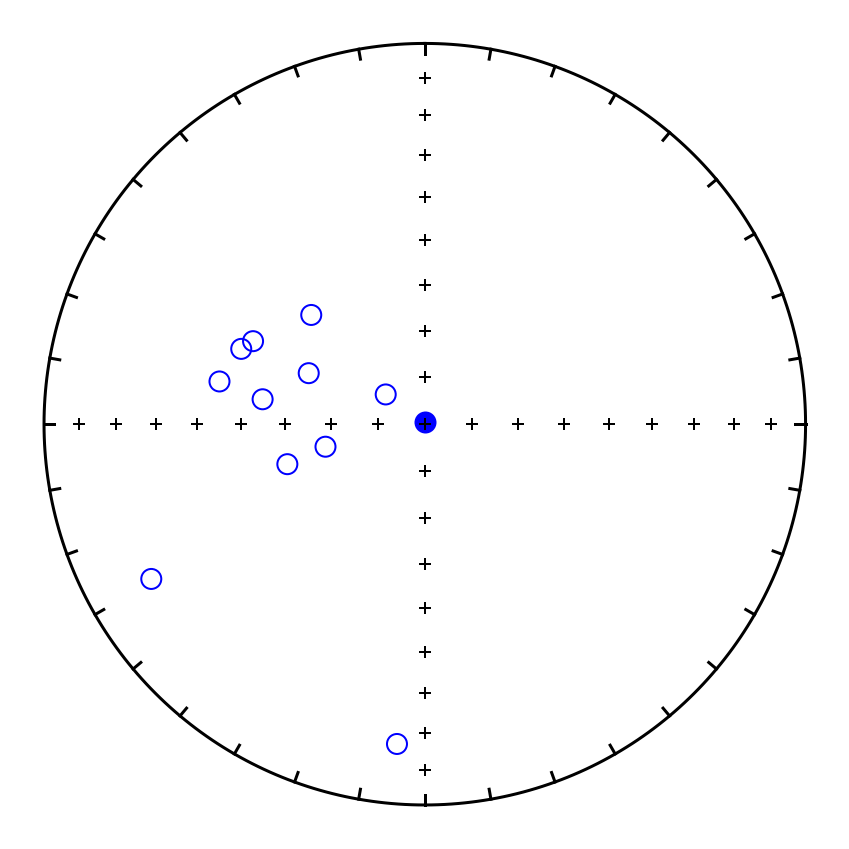

In [4]:
plt.figure(figsize=(6,6))
ipmag.plot_net()
ipmag.plot_di(Holder_OPRM['dec'], Holder_OPRM['inc'], color = 'blue', markersize = 100, label = 'OPRM holder')


## X standard sample

### OPRM X

I did 5 measurements of this sample on the SRM and 10 measurement of this sample on the OPRM. 

Directions match really well, but moment is consistently off. SRM gives a moment of 1.08 E-3 but OPRM gives consistently 8E-4 (emu).

In [5]:
X_OPRM = read_OPRM_file('X.csv')
X_OPRM = X_OPRM.drop(0)
X_OPRM = X_OPRM.reset_index()
X_OPRM

,index,DEMAG,CD,CI,M,X,Y,Z,S/D,S/H,Orientation,Date&Time,dec,inc
0,1,NRM,350.5,3.0,0.000743,0.000732,-0.000123,3.880000e-05,286.0,0,T_4MR_T+Z,1-Jun,350.461537,2.992278
1,2,NRM,355.0,0.9,0.000722,0.000719,-0.000063,1.080000e-05,1140.0,0,T_4MR_T+Z-Z,1-Jun,354.992436,0.857283
2,3,NRM,354.0,0.2,0.001100,0.001090,-0.000115,3.990000e-06,126.0,0,T_4MR_T+Z-Z,1-Jun,353.977313,0.208576
3,4,NRM,358.7,1.0,0.001080,0.001080,-0.000024,1.930000e-05,139.0,0,T_4MR_T+Z-Z,2-Jun,358.705760,1.023527
4,5,NRM,356.1,1.1,0.000841,0.000839,-0.000058,1.580000e-05,1140.0,0,T_4MR_T+Z-Z,2-Jun,356.059032,1.076313
5,6,NRM,355.3,0.1,0.000913,0.000910,-0.000075,1.480000e-06,15.5,0,T_4MR_T+Z-Z,2-Jun,355.269708,0.092867
6,7,NRM,355.9,1.0,0.000867,0.000864,-0.000062,1.530000e-05,100.0,0,T_4MR_T+Z-Z,2-Jun,355.888935,1.011897
7,8,NRM,356.0,0.3,0.000863,0.000860,-0.000060,4.630000e-06,94.9,0,T_4MR_T+Z-Z,2-Jun,356.028977,0.307721
8,9,NRM,354.9,0.3,0.000640,0.000638,-0.000056,3.520000e-06,74.0,0,T_4MR_T+Z-Z,2-Jun,354.948114,0.314883
9,10,NRM,356.4,1.0,0.000873,0.000871,-0.000055,1.580000e-05,752.0,0,T_4MR_T+Z-Z,2-Jun,356.380257,1.037163


### SRM X

In [6]:
X_SRM_DF = read_SRM_file('SRM_data/X')
X_SRM_DF = X_SRM_DF.drop(3)
X_SRM_DF = X_SRM_DF.reset_index()
X_SRM_DF

,index,dec,inc,Ms
0,0,5.8,-0.6,0.00108
1,1,4.3,-0.6,0.00108
2,2,3.6,-0.6,0.00108
3,4,2.8,-0.6,0.00108
4,5,4.9,-0.6,0.00107
5,6,358.9,-0.6,0.00108
6,7,6.7,-0.6,0.00107
7,8,5.7,-0.6,0.00108
8,9,2.1,-0.6,0.00108


In [7]:
X_OPRM_mean = ipmag.fisher_mean(0-X_OPRM['dec'], -X_OPRM['inc'])
X_SRM_mean = ipmag.fisher_mean(X_SRM_DF['dec'].tolist(), X_SRM_DF['inc'].tolist())

In [8]:
ipmag.print_direction_mean(X_OPRM_mean)


Dec: 4.7  Inc: -0.8
Number of directions in mean (n): 14
Angular radius of 95% confidence (a_95): 0.9
Precision parameter (k) estimate: 1806.0


In [9]:
ipmag.print_direction_mean(X_SRM_mean)

Dec: 3.9  Inc: -0.6
Number of directions in mean (n): 9
Angular radius of 95% confidence (a_95): 1.5
Precision parameter (k) estimate: 1158.0


In [10]:
angle_X = pmag.angle([X_OPRM_mean['dec'], X_OPRM_mean['inc']], [X_SRM_mean['dec'], X_SRM_mean['inc']])

### equal area plot for the directions

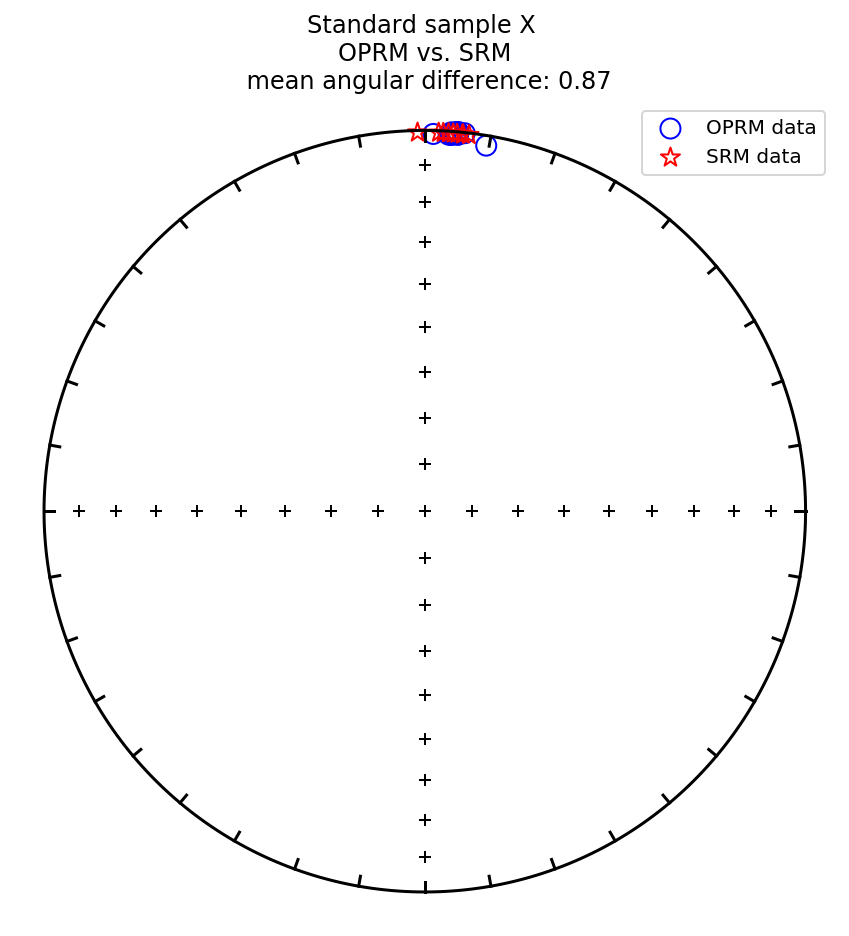

In [11]:
plt.figure(figsize=(6,6))
ipmag.plot_net()
ipmag.plot_di(0-X_OPRM['dec'], -X_OPRM['inc'], color = 'blue', markersize = 100, label = 'OPRM data')
ipmag.plot_di(X_SRM_DF['dec'].tolist(), X_SRM_DF['inc'].tolist(), color = 'red', marker = '*', markersize = 100, label = 'SRM data')
plt.legend()
plt.title('Standard sample X \nOPRM vs. SRM\n mean angular difference: ' +str(round(angle_X[0], 2)))
plt.savefig('Figures/X_equall_area.pdf', bbox_inches='tight')
plt.show()

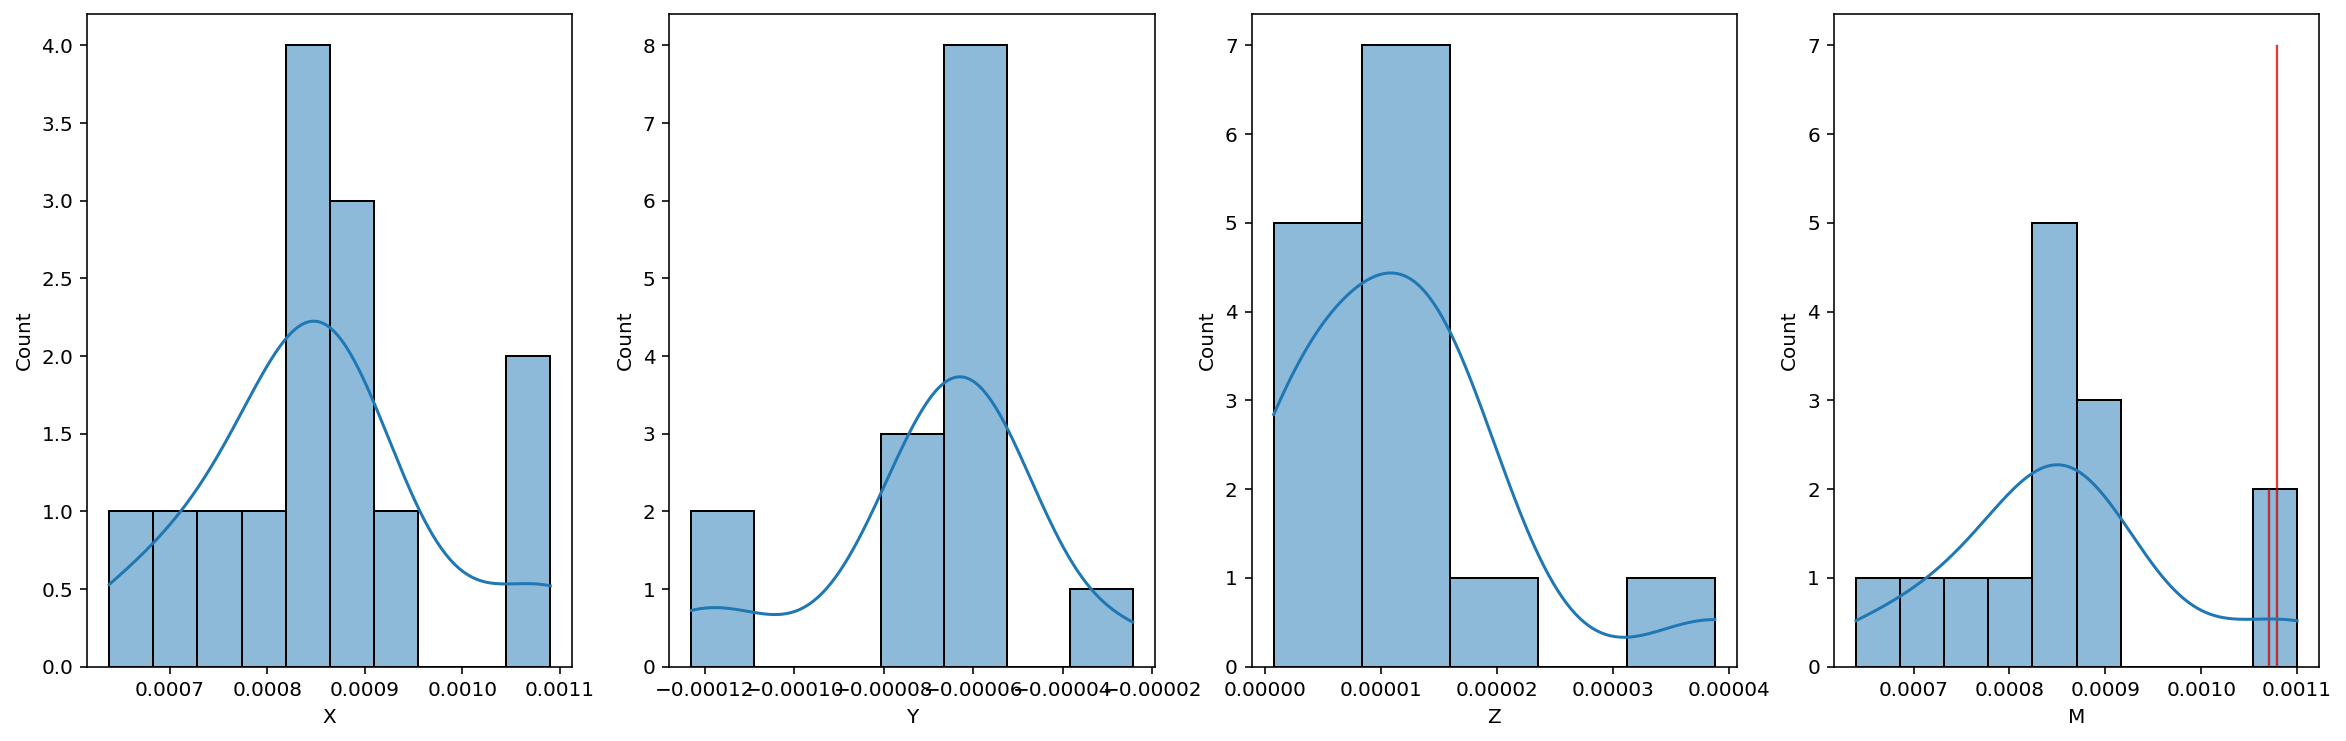

In [12]:
# plt.figure(figsize=(8,4))
fig, ax = plt.subplots(1,4, figsize=(20,6))
sns.histplot(data=X_OPRM, x="X", kde=True, ax=ax[0])
sns.histplot(data=X_OPRM, x="Y", kde=True, ax=ax[1])
sns.histplot(data=X_OPRM, x="Z", kde=True, ax=ax[2])
sns.histplot(data=X_OPRM, x="M", kde=True, ax=ax[3])
sns.histplot(data=X_SRM_DF, x="Ms", kde=False, color = 'red', ax=ax[3])
plt.show()

## Z standard sample

### OPRM Z


In [76]:
Z_OPRM = read_OPRM_file('Z.csv')
Z_OPRM = Z_OPRM[Z_OPRM['Orientation'] == 'T_4MR_T+Z-Z']
Z_OPRM = Z_OPRM.reset_index()
Z_OPRM = Z_OPRM.drop([2,4])
Z_OPRM = Z_OPRM.reset_index()
Z_OPRM

,level_0,index,DEMAG,CD,CI,M,X,Y,Z,S/D,S/H,Orientation,Date&Time,Unnamed: 11,dec,inc
0,0,3,NRM,259.3,86.4,0.000574,-0.000007,-0.000035,0.000573,39.3,0,T_4MR_T+Z-Z,19-Apr,2021 16:21,259.358908,86.392922
1,1,9,NRM,205.5,88.5,0.001040,-0.000025,-0.000012,0.001040,174.0,0,T_4MR_T+Z-Z,20-Apr,2021 12:34,205.633495,88.484920
2,3,14,NRM,144.1,87.1,0.000768,-0.000031,0.000023,0.000767,765.0,0,T_4MR_T+Z-Z,1-Jun,2021 13:08,144.135707,87.108090
3,5,16,NRM,208.6,87.6,0.000761,-0.000028,-0.000015,0.000760,35.8,0,T_4MR_T+Z-Z,1-Jun,2021 13:51,208.653453,87.595930
4,6,17,NRM,214.3,86.8,0.001160,-0.000053,-0.000036,0.001160,397.0,0,T_4MR_T+Z-Z,1-Jun,2021 14:19,214.260033,86.835825
5,7,18,NRM,209.0,86.9,0.001120,-0.000054,-0.000030,0.001120,96.4,0,T_4MR_T+Z-Z,2-Jun,2021 11:52,209.036415,86.872764
6,8,20,NRM,225.2,88.0,0.001060,-0.000026,-0.000026,0.001060,1180.0,0,T_4MR_T+Z-Z,2-Jun,2021 12:09,225.217854,87.990387


### SRM Z

In [77]:
Z_SRM_DF = read_SRM_file('SRM_data/Z')
# Z_SRM_DF = Z_SRM_DF.drop(3)
Z_SRM_DF = Z_SRM_DF.reset_index()
Z_SRM_DF

,index,dec,inc,Ms
0,0,134.5,-87.2,0.00102


In [78]:
Z_OPRM_mean = ipmag.fisher_mean(0-Z_OPRM['dec'], -Z_OPRM['inc'])

In [79]:
ipmag.print_direction_mean(Z_OPRM_mean)


Dec: 147.7  Inc: -87.8
Number of directions in mean (n): 7
Angular radius of 95% confidence (a_95): 1.3
Precision parameter (k) estimate: 2171.1


In [80]:
angle_Z = pmag.angle([Z_OPRM_mean['dec'], Z_OPRM_mean['inc']], [Z_SRM_DF['dec'][0], Z_SRM_DF['inc'][0]])

### equal area plot for the directions

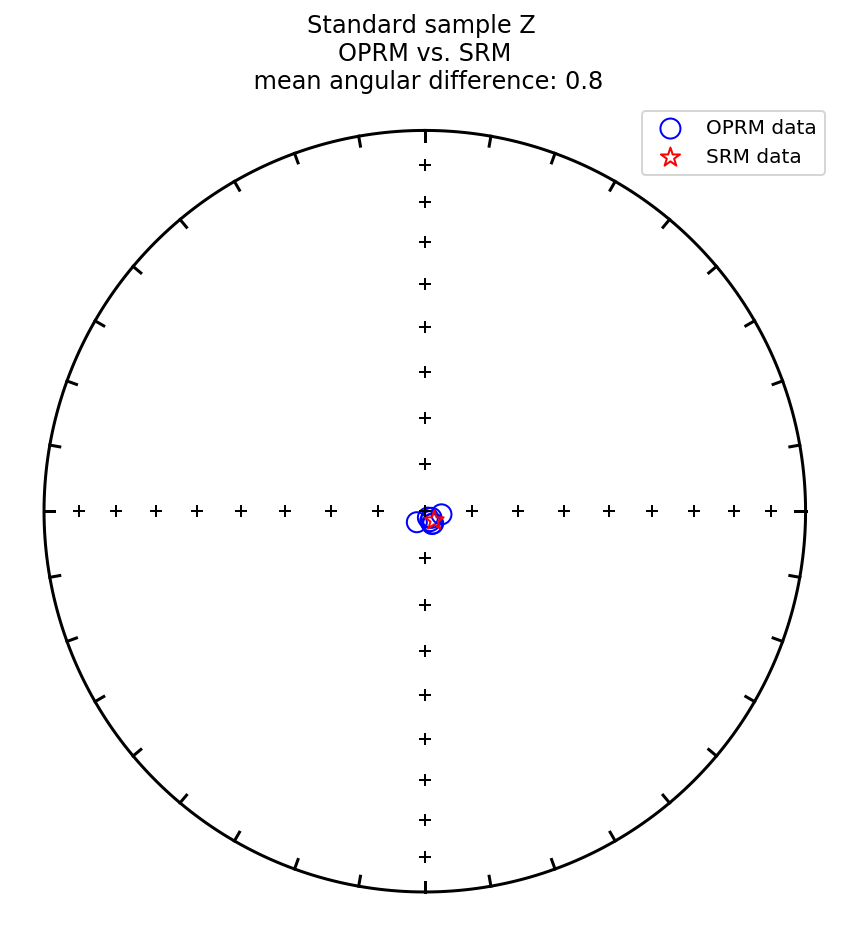

In [81]:
plt.figure(figsize=(6,6))
ipmag.plot_net()
ipmag.plot_di(0-Z_OPRM['dec'], -Z_OPRM['inc'], color = 'blue', markersize = 100, label = 'OPRM data')
ipmag.plot_di(Z_SRM_DF['dec'].tolist(), Z_SRM_DF['inc'].tolist(), color = 'red', marker = '*', markersize = 100, label = 'SRM data')
plt.legend()
plt.title('Standard sample Z \nOPRM vs. SRM\n mean angular difference: ' +str(round(angle_Z[0], 2)))
plt.savefig('Figures/Z_equall_area.pdf', bbox_inches='tight')
plt.show()

## GB1-2b

### OPRM GB1-2b

I did 1 measurement1 of this sample on the SRM and 10 measurement of this sample on the OPRM. 

Directions match really well, but moment is consistently off. SRM gives a moment of 4.53 E-3 but OPRM gives consistently 4E-3 (emu).

In [13]:
GB1_2b_OPRM = read_OPRM_file('GB1-2b.csv')
GB1_2b_OPRM = GB1_2b_OPRM.drop(1)
GB1_2b_OPRM = GB1_2b_OPRM.drop(9)
GB1_2b_OPRM = GB1_2b_OPRM.reset_index()
GB1_2b_OPRM

,index,DEMAG,CD,CI,M,X,Y,Z,S/D,S/H,Orientation,Date&Time,Unnamed: 11,dec,inc
0,0,NRM,357.0,-70.6,0.00835,0.00278,-0.000144,-0.00788,211.0,0,T_4MR_T+Z-Z,1-Jun,2021 14:35,357.034811,-70.543476
1,2,NRM,3.3,-70.4,0.00761,0.00254,0.000148,-0.00717,247.0,0,T_4MR_T+Z-Z,2-Jun,2021 12:20,3.334724,-70.462532
2,3,NRM,3.5,-72.4,0.00622,0.00187,0.000115,-0.00593,356.0,0,T_4MR_T+Z-Z,2-Jun,2021 16:10,3.519105,-72.466514
3,4,NRM,2.3,-71.4,0.00626,0.00200,0.000080,-0.00593,4960.0,0,T_4MR_T+Z-Z,2-Jun,2021 16:15,2.290610,-71.348515
4,5,NRM,6.0,-71.4,0.00612,0.00194,0.000205,-0.00581,992.0,0,T_4MR_T+Z-Z,2-Jun,2021 16:18,6.032066,-71.439694
5,6,NRM,4.1,-72.5,0.00627,0.00188,0.000135,-0.00598,1140.0,0,T_4MR_T+Z-Z,2-Jun,2021 16:20,4.107275,-72.505629
6,7,NRM,1.9,-72.6,0.00625,0.00186,0.000061,-0.00597,369.0,0,T_4MR_T+Z-Z,2-Jun,2021 16:21,1.862996,-72.686565
7,8,NRM,3.1,-72.1,0.00623,0.00191,0.000104,-0.00593,368.0,0,T_4MR_T+Z-Z,2-Jun,2021 16:23,3.116692,-72.121950
8,10,NRM,2.6,-71.6,0.00609,0.00192,0.000088,-0.00578,866.0,0,T_4MR_T+Z-Z,2-Jun,2021 16:30,2.612308,-71.606719
9,11,NRM,1.3,-71.7,0.00621,0.00195,0.000044,-0.00589,666.0,0,T_4MR_T+Z-Z,2-Jun,2021 16:32,1.298482,-71.677471


### SRM GB1-2b

In [14]:
GB1_2b_SRM_DF = read_SRM_file('SRM_data/GB1-2b')
# GB1_2b_SRM_DF = GB1_2b_SRM_DF.drop(3)
# GB1_2b_SRM_DF = GB1_2b_SRM_DF.reset_index()
GB1_2b_SRM_DF

,dec,inc,Ms
0,3.3,70.7,0.00453
1,2.7,70.7,0.00453
2,5.5,70.7,0.00453
3,4.2,70.8,0.00453
4,4.7,70.7,0.00453


In [15]:
GB1_2b_OPRM_mean = ipmag.fisher_mean(0-GB1_2b_OPRM['dec'], -GB1_2b_OPRM['inc'])
GB1_2b_SRM_mean = ipmag.fisher_mean(GB1_2b_SRM_DF['dec'].tolist(), GB1_2b_SRM_DF['inc'].tolist())

In [16]:
ipmag.print_direction_mean(GB1_2b_OPRM_mean)


Dec: 357.7  Inc: 71.7
Number of directions in mean (n): 12
Angular radius of 95% confidence (a_95): 0.5
Precision parameter (k) estimate: 6691.3


In [17]:
ipmag.print_direction_mean(GB1_2b_SRM_mean)

Dec: 4.1  Inc: 70.7
Number of directions in mean (n): 5
Angular radius of 95% confidence (a_95): 0.3
Precision parameter (k) estimate: 48123.5


In [18]:
GB1_2b_angle = pmag.angle([GB1_2b_OPRM_mean['dec'], GB1_2b_OPRM_mean['inc']], [GB1_2b_SRM_mean['dec'], GB1_2b_SRM_mean['inc']])

### equal area plot for the directions

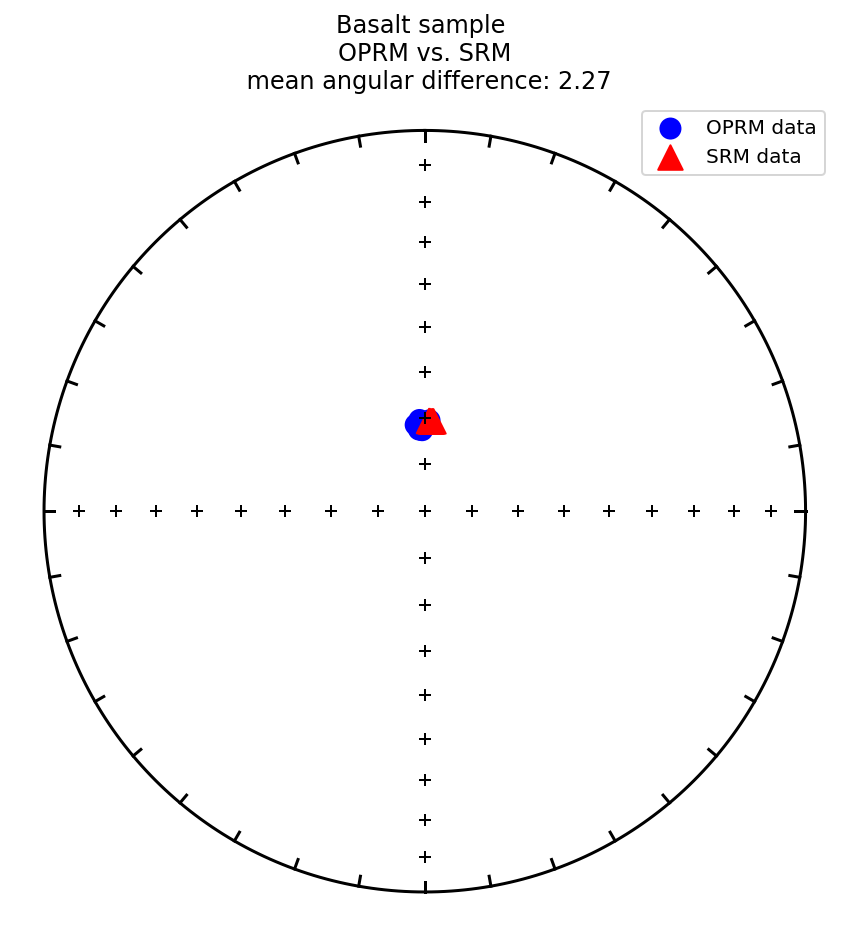

In [160]:
plt.figure(figsize=(6,6))
ipmag.plot_net()
ipmag.plot_di(0-GB1_2b_OPRM['dec'], -GB1_2b_OPRM['inc'], color = 'blue', markersize = 100, label = 'OPRM data')
ipmag.plot_di(GB1_2b_SRM_DF['dec'].tolist(), GB1_2b_SRM_DF['inc'].tolist(), color = 'red', marker = '^', markersize = 150, label = 'SRM data')
plt.legend()
plt.title('Basalt sample \nOPRM vs. SRM\n mean angular difference: ' +str(round(GB1_2b_angle[0], 2)))
plt.savefig('Figures/GB1_2b_equall_area.pdf', bbox_inches='tight')
plt.show()

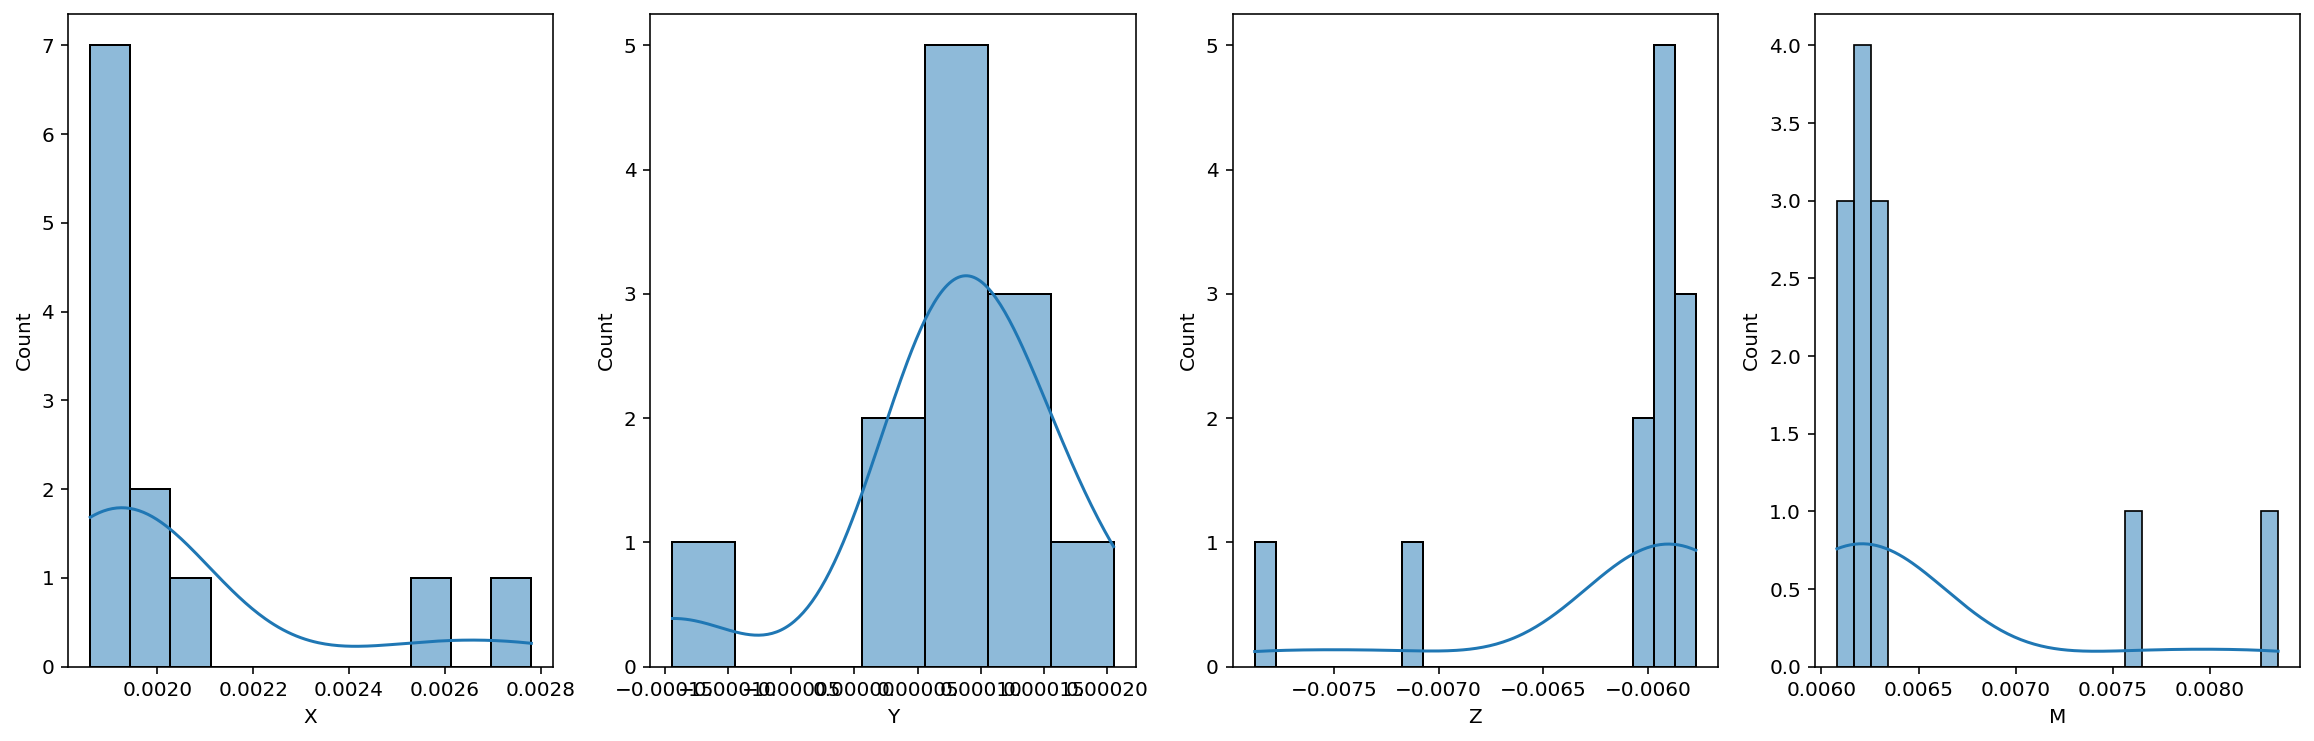

In [20]:
# plt.figure(figsize=(8,4))
fig, ax = plt.subplots(1,4, figsize=(20,6))
sns.histplot(data=GB1_2b_OPRM, x="X", kde=True, ax=ax[0])
sns.histplot(data=GB1_2b_OPRM, x="Y", kde=True, ax=ax[1])
sns.histplot(data=GB1_2b_OPRM, x="Z", kde=True, ax=ax[2])
sns.histplot(data=GB1_2b_OPRM, x="M", kde=True, ax=ax[3])
# sns.histplot(data=GB1_2b_SRM_DF, x="Ms", kde=False, color = 'red', ax=ax[3])
plt.show()

## WP-3b

### OPRM WP-3b


In [21]:
WP_3b_OPRM = read_OPRM_file('WP-3b.csv')

WP_3b_OPRM = WP_3b_OPRM.reset_index()
WP_3b_OPRM

,index,DEMAG,CD,CI,M,X,Y,Z,S/D,S/H,Orientation,Date&Time,Unnamed: 11,dec,inc
0,0,NRM,16.1,64.8,0.001000,0.000410,0.000118,0.000908,9990.0,0,T_4MR_T+Z-Z,2-Jun,2021 16:39,16.056077,64.832538
1,1,NRM,18.4,66.7,0.000803,0.000301,0.000100,0.000738,792.0,0,T_4MR_T+Z-Z,2-Jun,2021 16:42,18.377824,66.743002
2,2,NRM,14.9,64.9,0.000995,0.000408,0.000109,0.000901,971.0,0,T_4MR_T+Z-Z,2-Jun,2021 16:45,14.957636,64.886970
3,3,NRM,17.1,64.8,0.000971,0.000395,0.000121,0.000879,7120.0,0,T_4MR_T+Z-Z,2-Jun,2021 16:46,17.031351,64.827147
4,4,NRM,17.0,64.6,0.001010,0.000412,0.000126,0.000909,6050.0,0,T_4MR_T+Z-Z,2-Jun,2021 16:48,17.004955,64.640572
5,5,NRM,16.1,64.8,0.000981,0.000401,0.000116,0.000888,1760.0,0,T_4MR_T+Z-Z,2-Jun,2021 16:50,16.133930,64.822194
6,6,NRM,15.8,65.2,0.000969,0.000392,0.000111,0.000880,755.0,0,T_4MR_T+Z-Z,2-Jun,2021 16:51,15.810173,65.157334
7,7,NRM,16.6,64.9,0.000976,0.000396,0.000118,0.000884,12000.0,0,T_4MR_T+Z-Z,2-Jun,2021 16:54,16.592993,64.947264
8,8,NRM,15.4,65.3,0.000984,0.000397,0.000109,0.000893,1220.0,0,T_4MR_T+Z-Z,2-Jun,2021 16:57,15.352768,65.249312
9,9,NRM,17.1,65.1,0.000993,0.000400,0.000123,0.000900,5480.0,0,T_4MR_T+Z-Z,2-Jun,2021 16:58,17.092663,65.062401


### SRM WP-3b

In [22]:
WP_3b_SRM_DF = read_SRM_file('SRM_data/WP-3b')
# GB1_2b_SRM_DF = GB1_2b_SRM_DF.drop(3)
# GB1_2b_SRM_DF = GB1_2b_SRM_DF.reset_index()
WP_3b_SRM_DF

,dec,inc,Ms
0,19.1,61.3,0.000711
1,14.6,61.4,0.000711
2,18.5,61.4,0.000711
3,14.7,61.4,0.000711
4,18.7,61.4,0.000711


In [23]:
WP_3b_OPRM_mean = ipmag.fisher_mean(WP_3b_OPRM['dec'], WP_3b_OPRM['inc'])
WP_3b_SRM_mean = ipmag.fisher_mean(WP_3b_SRM_DF['dec'].tolist(), WP_3b_SRM_DF['inc'].tolist())

In [24]:
ipmag.print_direction_mean(WP_3b_OPRM_mean)

Dec: 16.4  Inc: 65.1
Number of directions in mean (n): 10
Angular radius of 95% confidence (a_95): 0.4
Precision parameter (k) estimate: 12404.4


In [25]:
ipmag.print_direction_mean(WP_3b_SRM_mean)

Dec: 17.1  Inc: 61.4
Number of directions in mean (n): 5
Angular radius of 95% confidence (a_95): 1.0
Precision parameter (k) estimate: 5568.7


In [45]:
WP_3b_angle = pmag.angle([WP_3b_OPRM_mean['dec'], WP_3b_OPRM_mean['inc']], [WP_3b_SRM_mean['dec'], WP_3b_SRM_mean['inc']])

In [46]:
WP_3b_angle

array([3.737609874603049])

### equal area plot for the directions

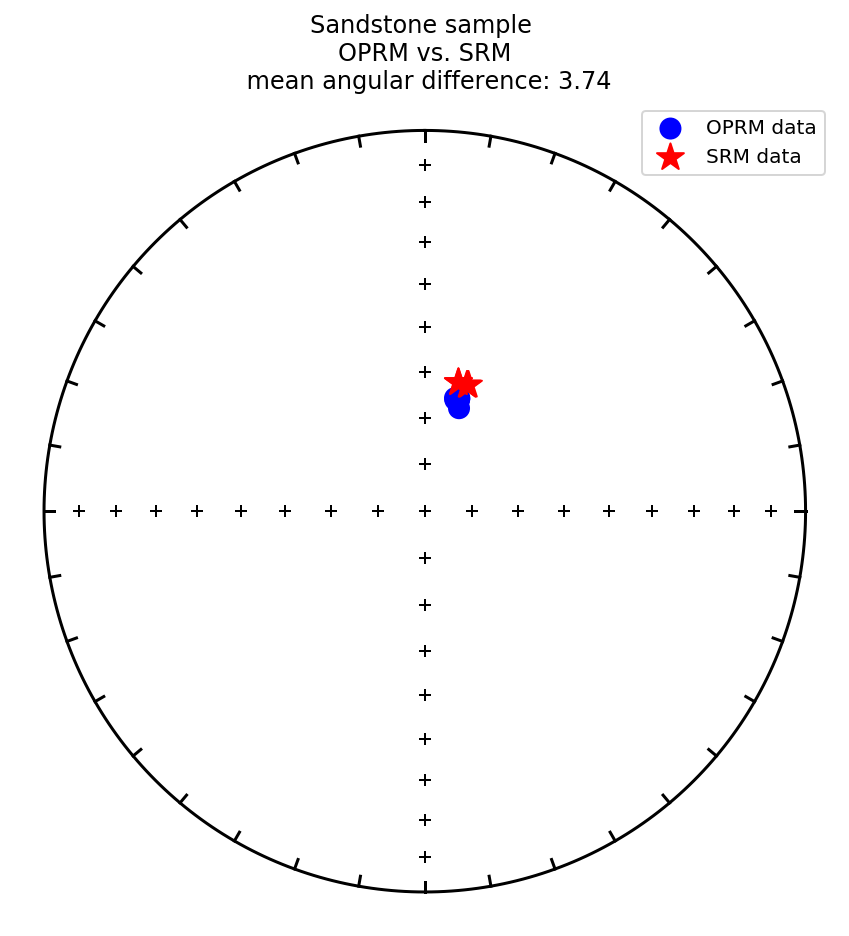

In [47]:
plt.figure(figsize=(6,6))
ipmag.plot_net()
ipmag.plot_di(WP_3b_OPRM['dec'], WP_3b_OPRM['inc'], color = 'blue', markersize = 100, label = 'OPRM data')
ipmag.plot_di(WP_3b_SRM_DF['dec'].tolist(), WP_3b_SRM_DF['inc'].tolist(), color = 'red', marker = '*', markersize = 200, label = 'SRM data')
plt.legend()
plt.title('Sandstone sample \nOPRM vs. SRM\n mean angular difference: ' +str(round(WP_3b_angle[0], 2)))
plt.savefig('Figures/WP_3b_equall_area.pdf', bbox_inches='tight')
plt.show()

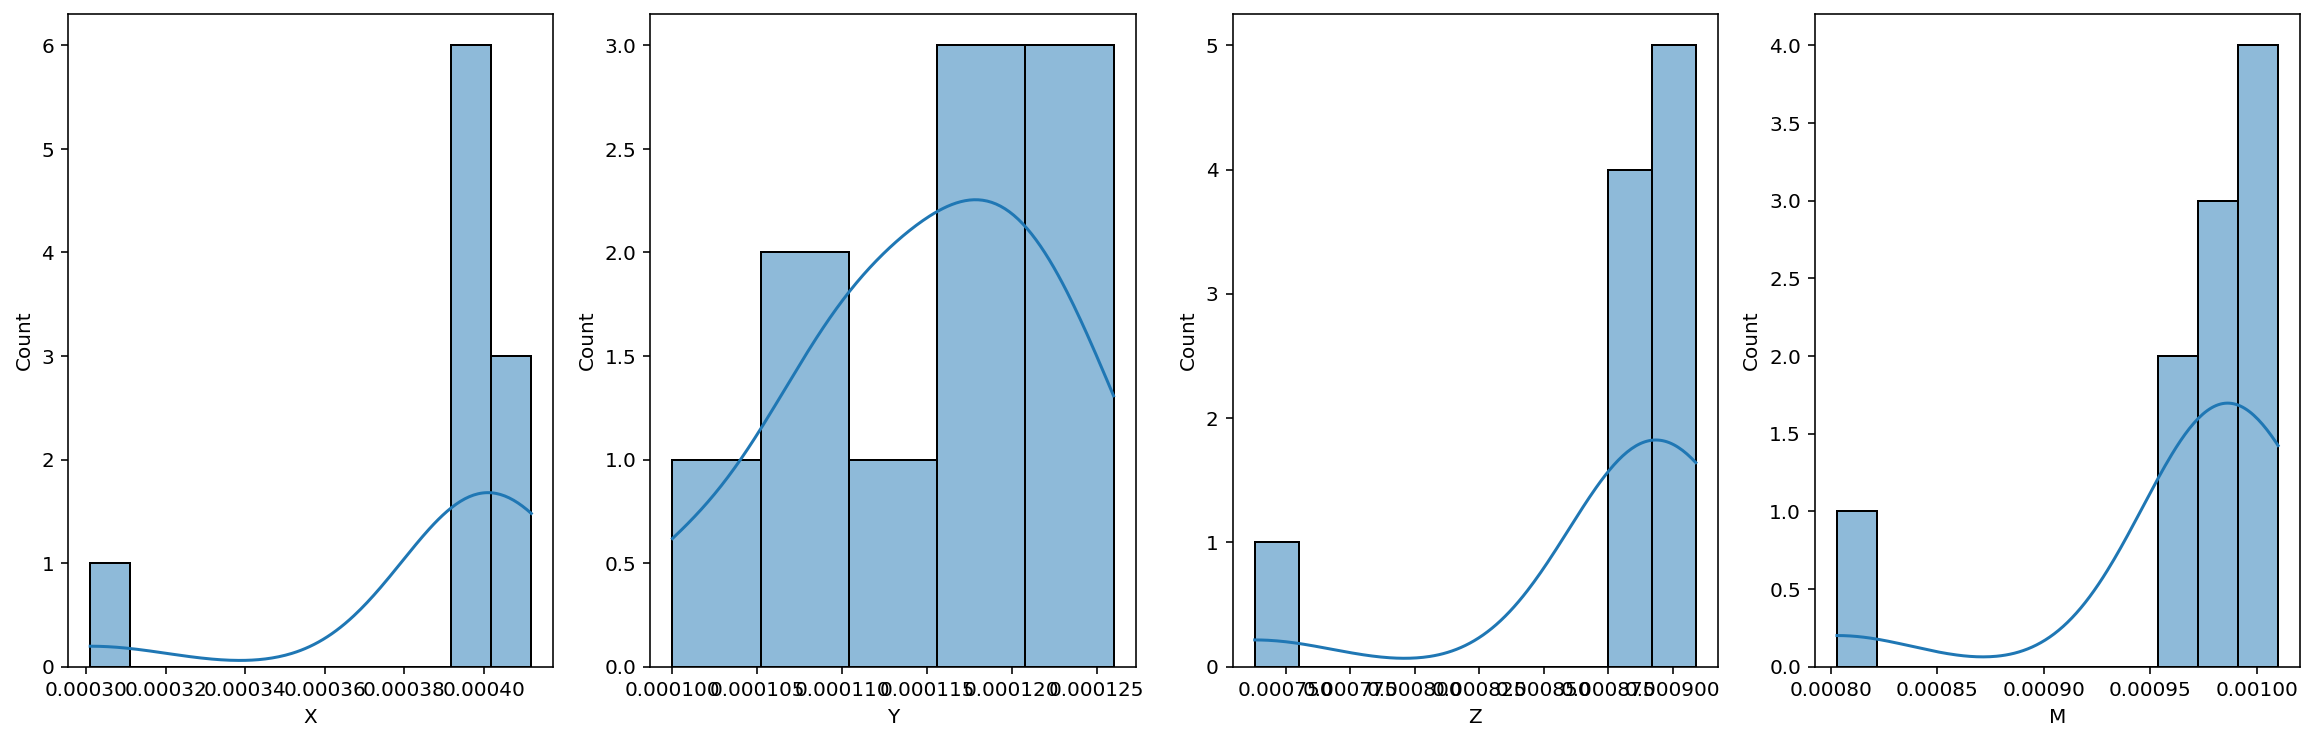

In [28]:
# plt.figure(figsize=(8,4))
fig, ax = plt.subplots(1,4, figsize=(20,6))
sns.histplot(data=WP_3b_OPRM, x="X", kde=True, ax=ax[0])
sns.histplot(data=WP_3b_OPRM, x="Y", kde=True, ax=ax[1])
sns.histplot(data=WP_3b_OPRM, x="Z", kde=True, ax=ax[2])
sns.histplot(data=WP_3b_OPRM, x="M", kde=True, ax=ax[3])
# sns.histplot(data=WP_3b_SRM_DF, x="Ms", kde=False, color = 'red', ax=ax[3])
plt.show()

## T1-84b

### OPRM T1-84b

I did 1 measurement of this sample on the SRM and 10 measurement of this sample on the OPRM. 

Directions match really well, but moment is consistently off. SRM gives a moment of 7.1 E-4 but OPRM gives consistently 9 E-4 to 1E-3(emu).

In [29]:
T1_84b_OPRM = read_OPRM_file('T1-84b.csv')
# T1_84b_OPRM = T1_84b_OPRM.drop(0)
# T1_84b_OPRM = T1_84b_OPRM.reset_index()
T1_84b_OPRM

,DEMAG,CD,CI,M,X,Y,Z,S/D,S/H,Orientation,Date&Time,Unnamed: 11,dec,inc
0,NRM,231.5,-47.9,0.000007,-0.000003,-0.000003,-0.000005,278.0,0,T_4MR_T+Z-Z,2-Jun,2021 17:00,231.585481,-47.930716
1,NRM,231.8,-47.8,0.000006,-0.000003,-0.000003,-0.000005,33.3,0,T_4MR_T+Z-Z,2-Jun,2021 17:04,231.753574,-47.773133
2,NRM,226.7,-47.1,0.000007,-0.000003,-0.000003,-0.000005,36.7,0,T_4MR_T+Z-Z,2-Jun,2021 17:05,226.647029,-47.127339
3,NRM,233.3,-48.4,0.000006,-0.000003,-0.000003,-0.000005,15.4,0,T_4MR_T+Z-Z,2-Jun,2021 17:07,233.291271,-48.429995
4,NRM,231.5,-47.7,0.000006,-0.000003,-0.000003,-0.000005,18.0,0,T_4MR_T+Z-Z,2-Jun,2021 17:08,231.504011,-47.745671
5,NRM,232.2,-47.8,0.000007,-0.000003,-0.000004,-0.000005,90.6,0,T_4MR_T+Z-Z,2-Jun,2021 17:10,232.221891,-47.751593
6,NRM,230.9,-46.7,0.000007,-0.000003,-0.000004,-0.000005,80.5,0,T_4MR_T+Z-Z,2-Jun,2021 17:12,230.954107,-46.706360
7,NRM,231.1,-47.3,0.000007,-0.000003,-0.000004,-0.000005,99.1,0,T_4MR_T+Z-Z,2-Jun,2021 17:14,231.097494,-47.277222
8,NRM,232.2,-47.5,0.000007,-0.000003,-0.000004,-0.000005,140.0,0,T_4MR_T+Z-Z,2-Jun,2021 17:15,232.146580,-47.521050
9,NRM,231.5,-46.7,0.000007,-0.000003,-0.000004,-0.000005,196.0,0,T_4MR_T+Z-Z,2-Jun,2021 17:17,231.517273,-46.723634


### SRM T1-84b

In [30]:
T1_84b_SRM_DF = read_SRM_file('SRM_data/T1-84b')
T1_84b_SRM_DF

,dec,inc,Ms
0,228.6,-45.9,0.000005
1,232.3,-45.8,0.000005
2,233.0,-45.9,0.000005
3,229.9,-45.8,0.000005
4,229.9,-45.7,0.000005


In [31]:
T1_84b_OPRM_mean = ipmag.fisher_mean(T1_84b_OPRM['dec'], T1_84b_OPRM['inc'])
T1_84b_SRM_mean = ipmag.fisher_mean(T1_84b_SRM_DF['dec'].tolist(), T1_84b_SRM_DF['inc'].tolist())

In [32]:
ipmag.print_direction_mean(T1_84b_OPRM_mean)


Dec: 231.3  Inc: -47.5
Number of directions in mean (n): 10
Angular radius of 95% confidence (a_95): 0.8
Precision parameter (k) estimate: 3850.8


In [33]:
ipmag.print_direction_mean(T1_84b_SRM_mean)

Dec: 230.7  Inc: -45.8
Number of directions in mean (n): 5
Angular radius of 95% confidence (a_95): 1.2
Precision parameter (k) estimate: 3983.1


In [34]:
T1_84b_angle = pmag.angle([T1_84b_OPRM_mean['dec'], T1_84b_OPRM_mean['inc']], [T1_84b_SRM_mean['dec'], T1_84b_SRM_mean['inc']])

### equal area plot for the directions

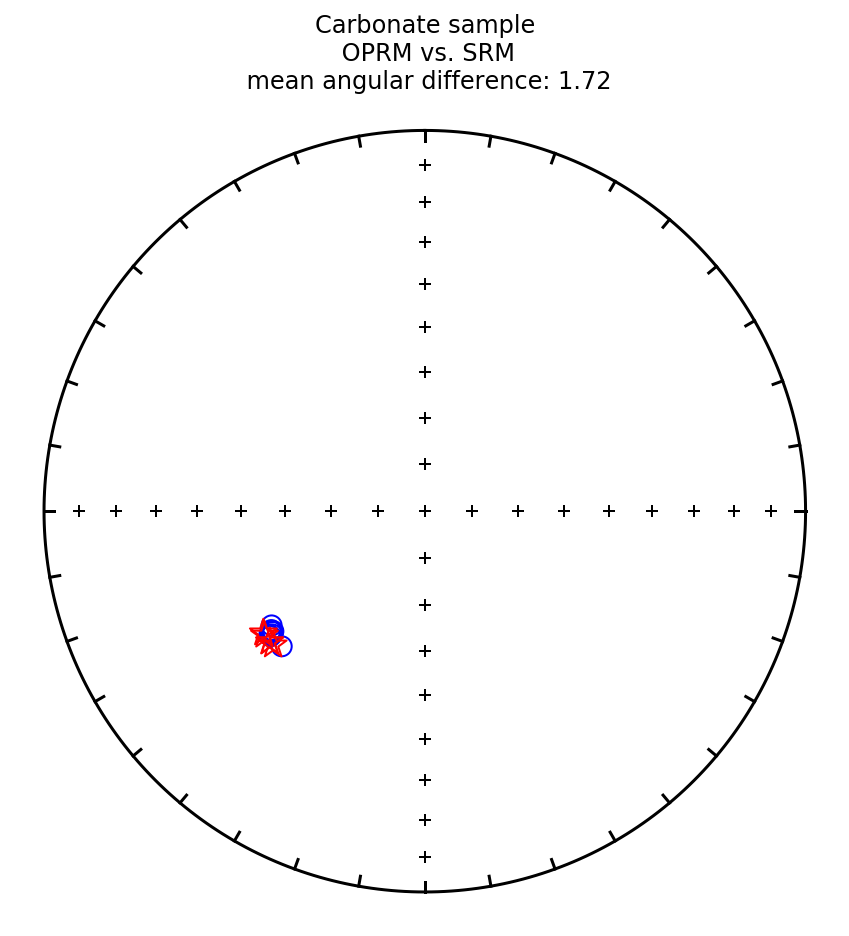

In [35]:
plt.figure(figsize=(6,6))
ipmag.plot_net()
ipmag.plot_di(T1_84b_OPRM['dec'], T1_84b_OPRM['inc'], color = 'blue', markersize = 100, label = 'OPRM data')
ipmag.plot_di(T1_84b_SRM_DF['dec'].tolist(), T1_84b_SRM_DF['inc'].tolist(), color = 'red', marker = '*', markersize = 200, label = 'SRM data')
plt.title('Carbonate sample\n OPRM vs. SRM\n mean angular difference: ' +str(round(T1_84b_angle[0], 2)))
plt.savefig('Figures/T1_84b_equall_area.pdf', bbox_inches='tight')
plt.show()

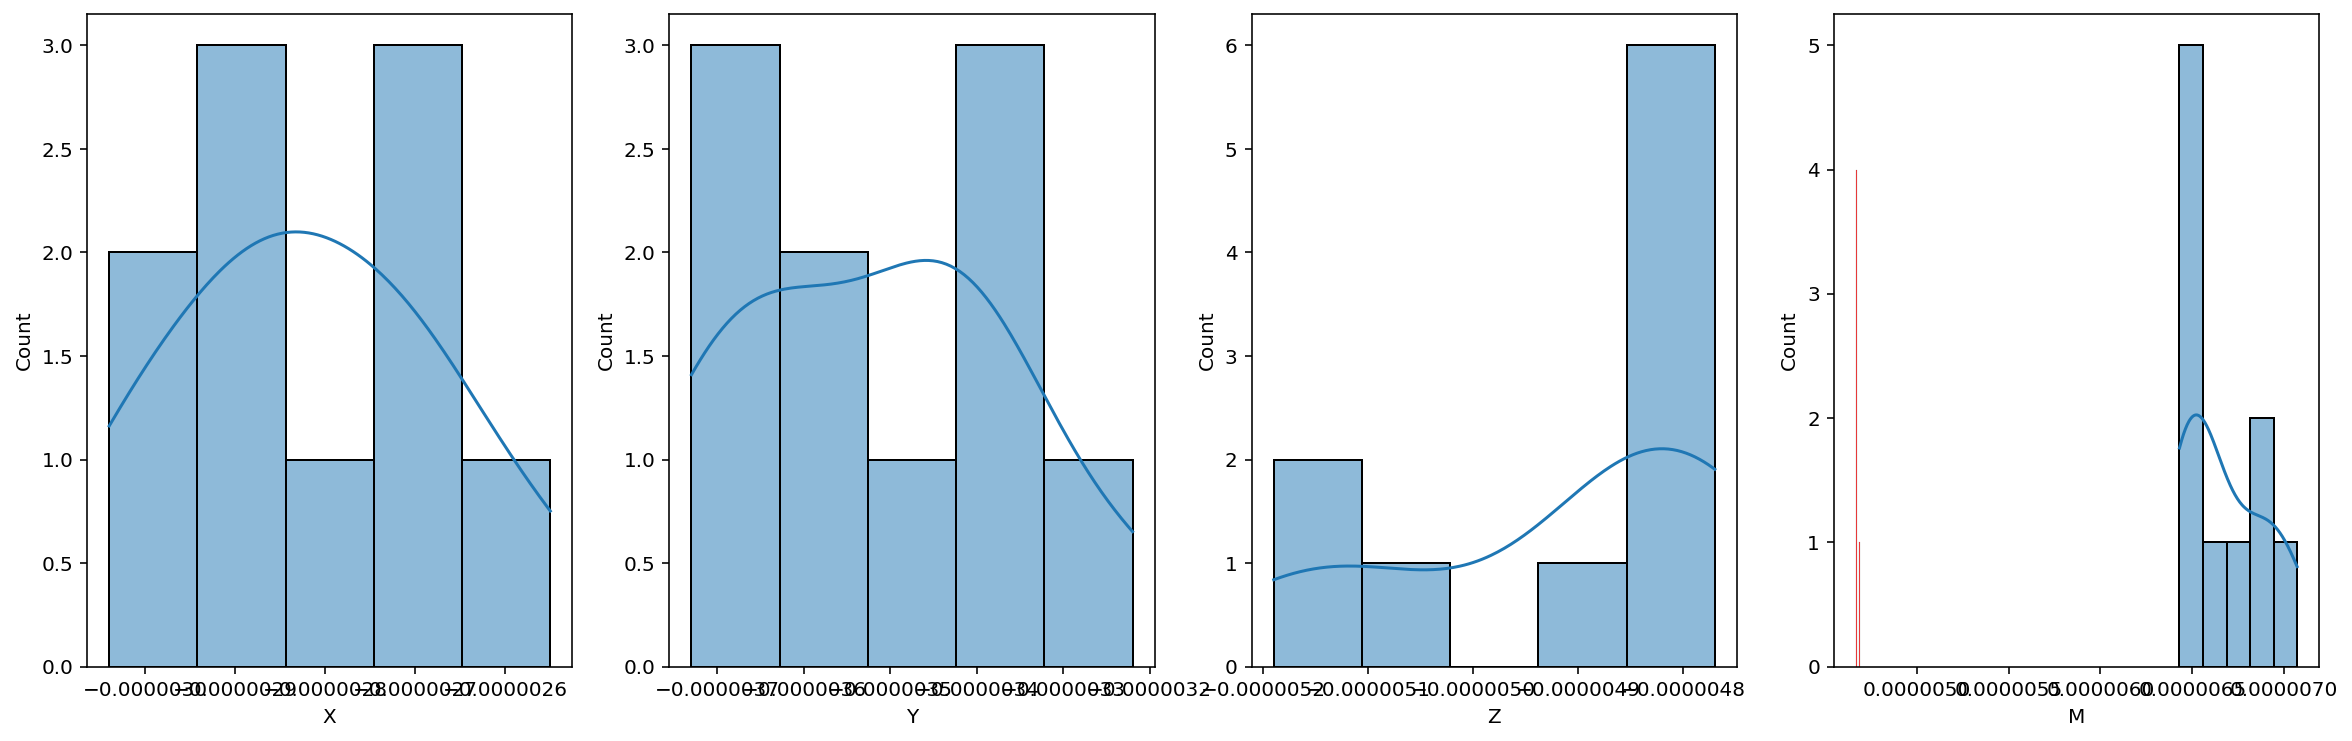

In [36]:
# plt.figure(figsize=(8,4))
fig, ax = plt.subplots(1,4, figsize=(20,6))
sns.histplot(data=T1_84b_OPRM, x="X", kde=True, ax=ax[0])
sns.histplot(data=T1_84b_OPRM, x="Y", kde=True, ax=ax[1])
sns.histplot(data=T1_84b_OPRM, x="Z", kde=True, ax=ax[2])
sns.histplot(data=T1_84b_OPRM, x="M", kde=True, ax=ax[3])
sns.histplot(data=T1_84b_SRM_DF, x="Ms", kde=False, color = 'red', ax=ax[3])
plt.show()

## signal to drift ratio summary

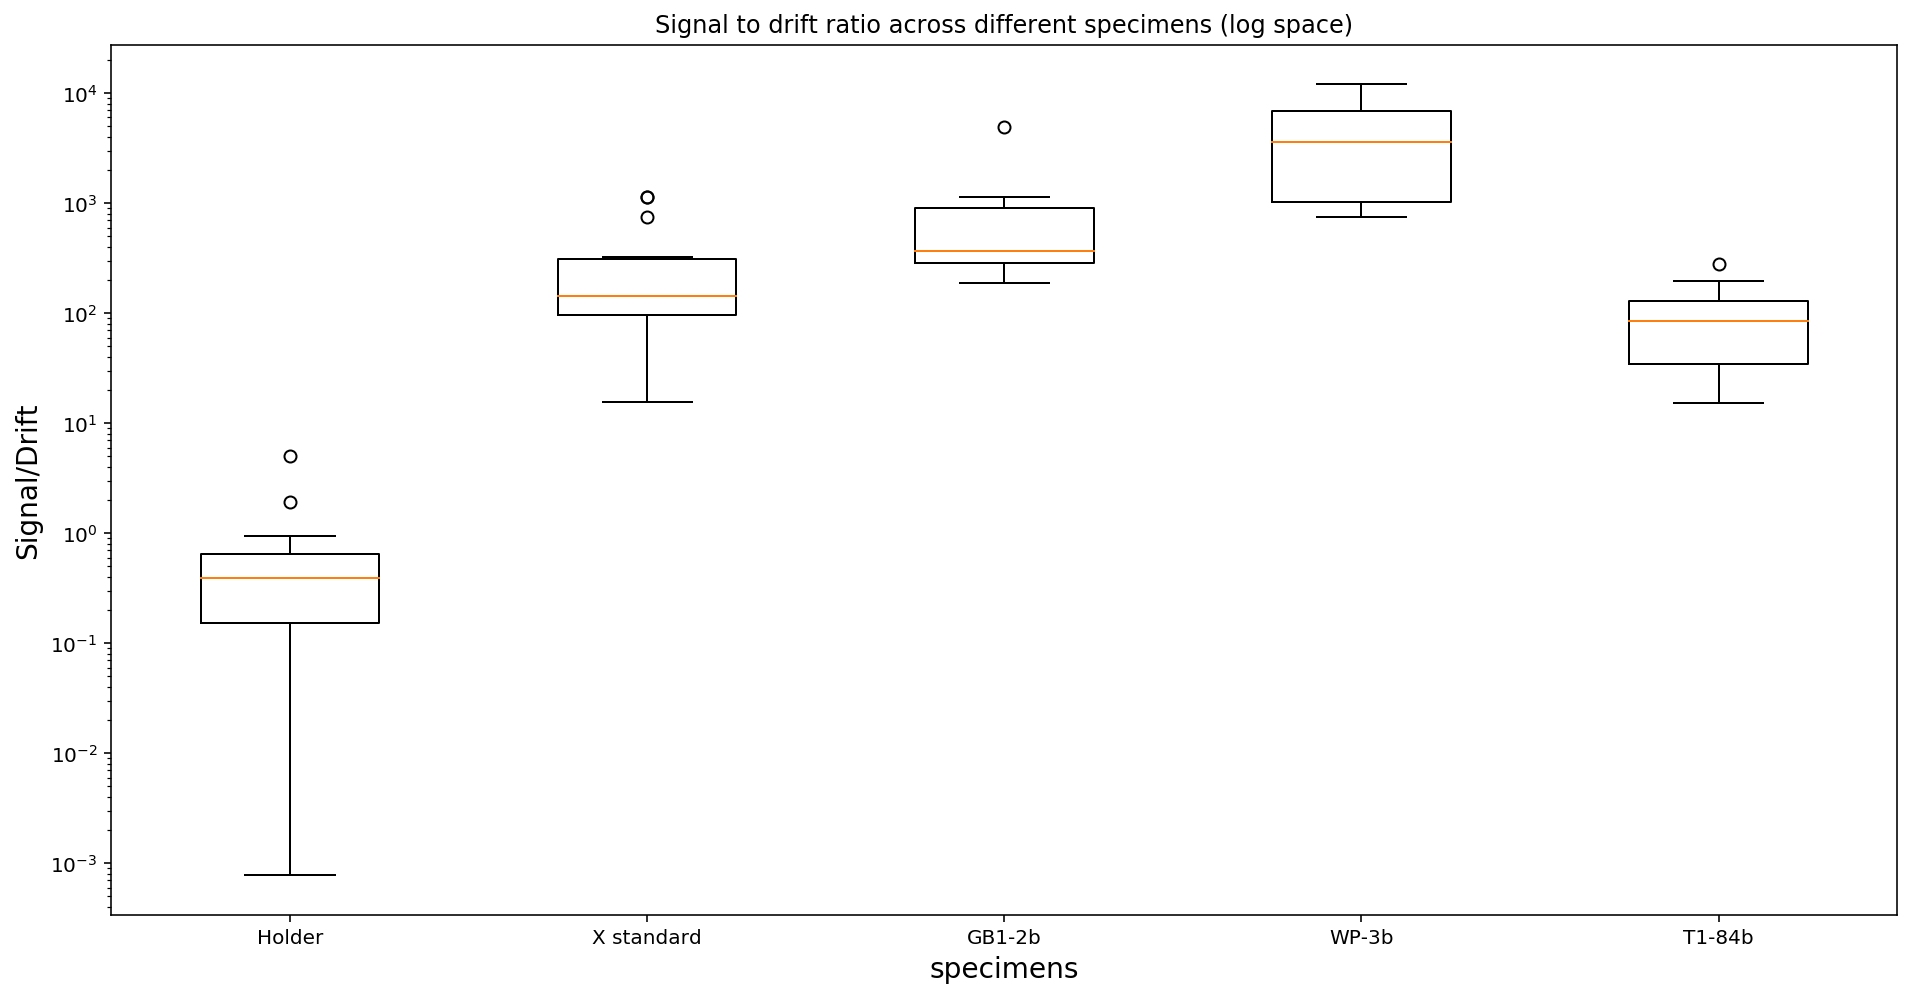

In [37]:
plt.figure(figsize=(16,8))
plt.boxplot([Holder_OPRM['S/D'], X_OPRM['S/D'], GB1_2b_OPRM['S/D'], WP_3b_OPRM['S/D'], T1_84b_OPRM['S/D']]);
plt.xticks([1,2,3,4,5], ['Holder', 'X standard', 'GB1-2b', 'WP-3b', 'T1-84b'])
plt.ylabel('Signal/Drift', fontdict={'fontsize':14})
plt.yscale('log')
plt.xlabel('specimens', fontdict={'fontsize':14})
plt.title('Signal to drift ratio across different specimens (log space)')
plt.savefig('Figures/Signal_drift_ratio.pdf')
plt.show()

## moment summary

In [139]:
df_OPRM = pd.DataFrame([Holder_OPRM['M'], X_OPRM['M'], GB1_2b_OPRM['M'], WP_3b_OPRM['M'], T1_84b_OPRM['M']]).T
df_OPRM.columns = ['Holder', 'X standard', 'GB1-2b', 'WP-3b', 'T1-84b']
# df_OPRM['hue'] = 'OPRM'
df_OPRM

,Holder,X standard,GB1-2b,WP-3b,T1-84b
0,2.980000e-05,0.000743,0.00835,0.001000,0.000007
1,3.630000e-08,0.000722,0.00761,0.000803,0.000006
2,1.710000e-07,0.001100,0.00622,0.000995,0.000007
3,1.740000e-07,0.001080,0.00626,0.000971,0.000006
4,2.030000e-07,0.000841,0.00612,0.001010,0.000006
5,1.300000e-07,0.000913,0.00627,0.000981,0.000007
6,2.220000e-07,0.000867,0.00625,0.000969,0.000007
7,1.890000e-07,0.000863,0.00623,0.000976,0.000007
8,1.350000e-07,0.000640,0.00609,0.000984,0.000007
9,1.470000e-07,0.000873,0.00621,0.000993,0.000007


In [140]:
df_SRM = pd.DataFrame([[], X_SRM_DF['Ms'], GB1_2b_SRM_DF['Ms'], WP_3b_SRM_DF['Ms'], T1_84b_SRM_DF['Ms']]).T
df_SRM.columns = ['Holder', 'X standard', 'GB1-2b', 'WP-3b', 'T1-84b']
# df_SRM['hue'] = 'SRM'
df_SRM

,Holder,X standard,GB1-2b,WP-3b,T1-84b
0,NaN,0.00108,0.00453,0.000711,0.000005
1,NaN,0.00108,0.00453,0.000711,0.000005
2,NaN,0.00108,0.00453,0.000711,0.000005
3,NaN,0.00108,0.00453,0.000711,0.000005
4,NaN,0.00107,0.00453,0.000711,0.000005
5,NaN,0.00108,NaN,NaN,NaN
6,NaN,0.00107,NaN,NaN,NaN
7,NaN,0.00108,NaN,NaN,NaN
8,NaN,0.00108,NaN,NaN,NaN


In [141]:
all_df = pd.concat([df_OPRM,df_SRM], axis=1)
all_df

,Holder,X standard,GB1-2b,WP-3b,T1-84b,Holder,X standard,GB1-2b,WP-3b,T1-84b
0,2.980000e-05,0.000743,0.00835,0.001000,0.000007,NaN,0.00108,0.00453,0.000711,0.000005
1,3.630000e-08,0.000722,0.00761,0.000803,0.000006,NaN,0.00108,0.00453,0.000711,0.000005
2,1.710000e-07,0.001100,0.00622,0.000995,0.000007,NaN,0.00108,0.00453,0.000711,0.000005
3,1.740000e-07,0.001080,0.00626,0.000971,0.000006,NaN,0.00108,0.00453,0.000711,0.000005
4,2.030000e-07,0.000841,0.00612,0.001010,0.000006,NaN,0.00107,0.00453,0.000711,0.000005
5,1.300000e-07,0.000913,0.00627,0.000981,0.000007,NaN,0.00108,NaN,NaN,NaN
6,2.220000e-07,0.000867,0.00625,0.000969,0.000007,NaN,0.00107,NaN,NaN,NaN
7,1.890000e-07,0.000863,0.00623,0.000976,0.000007,NaN,0.00108,NaN,NaN,NaN
8,1.350000e-07,0.000640,0.00609,0.000984,0.000007,NaN,0.00108,NaN,NaN,NaN
9,1.470000e-07,0.000873,0.00621,0.000993,0.000007,NaN,NaN,NaN,NaN,NaN


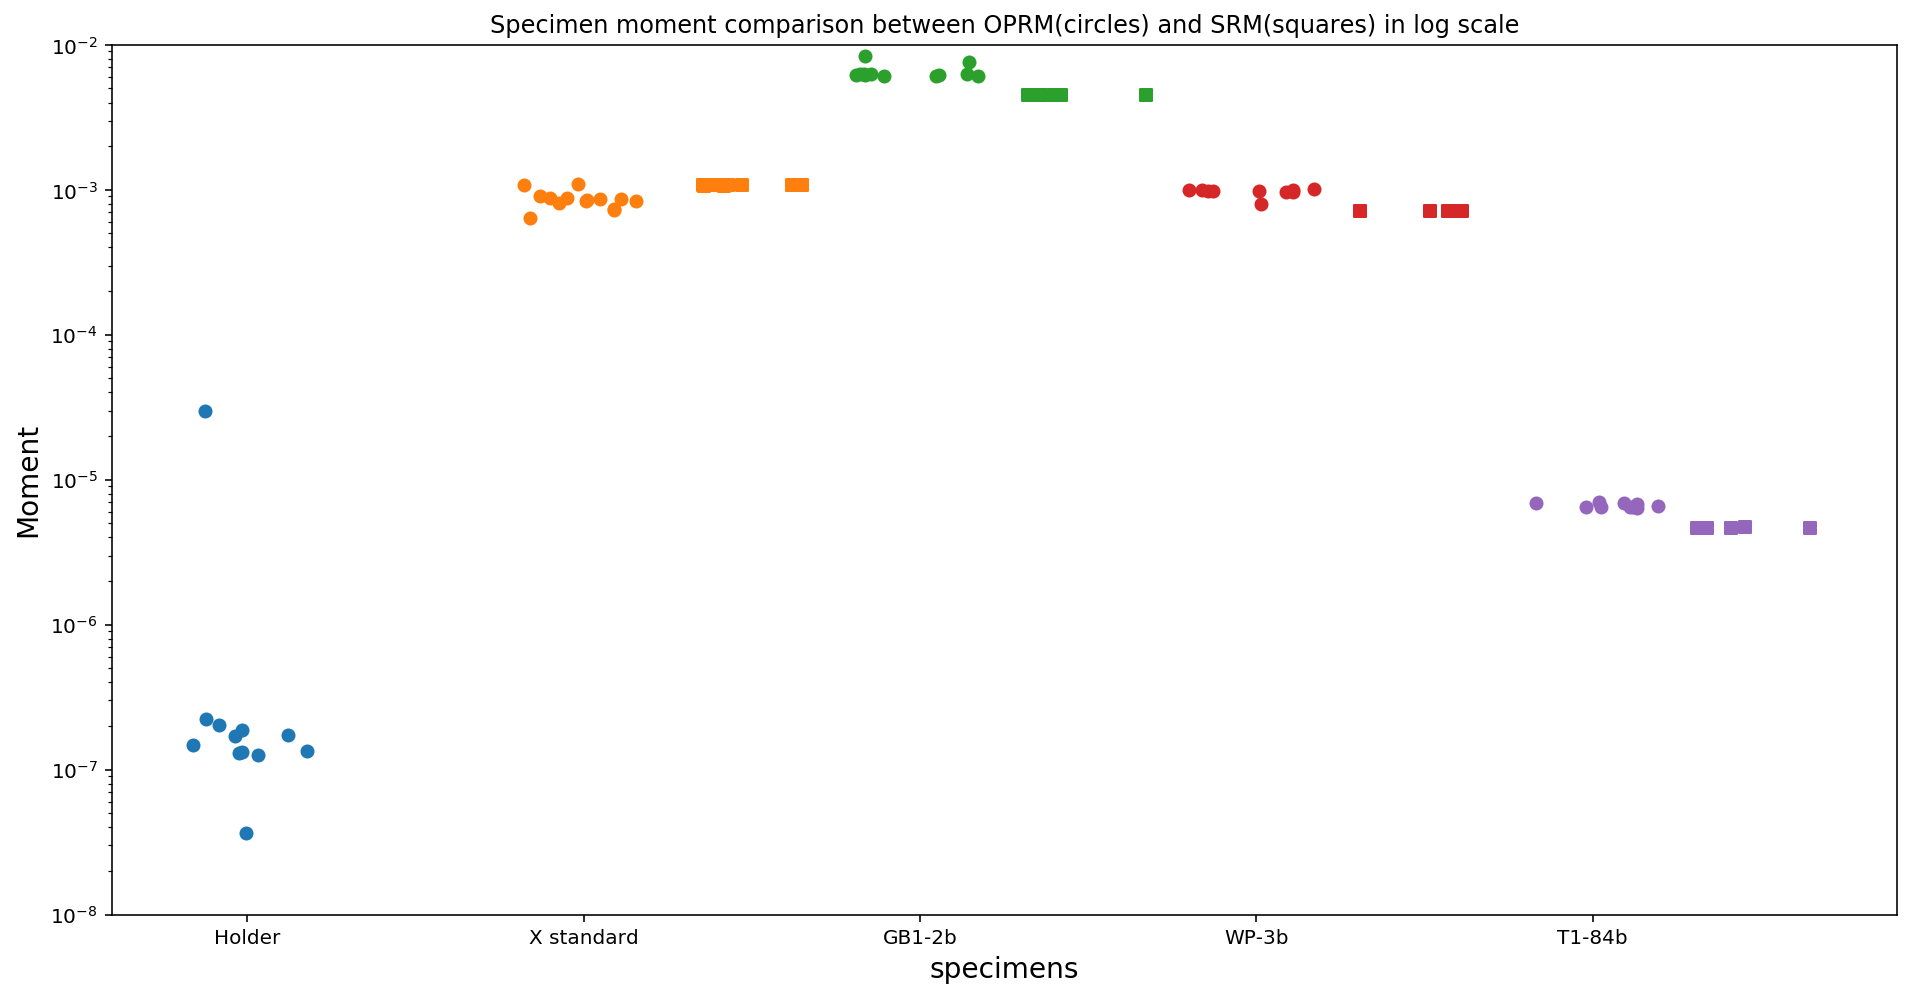

In [158]:

c1 = 'b'
c2 = 'r'
plt.figure(figsize=(16,8))
def stripplot(list_of_list, shift=0, random=False, marker='o', label=None):

    for i in range(len(list_of_list)):
        for j in list_of_list[i]:
            if random:
                plt.scatter(i+shift+np.random.uniform(-0.2,0.2), j, color = 'C'+str(i), marker = marker, label = label)
            else:
                plt.scatter(i+shift, j, color = 'C'+str(i), marker = marker, label = label)

                   
stripplot([Holder_OPRM['M'], X_OPRM['M'], GB1_2b_OPRM['M'], WP_3b_OPRM['M'], T1_84b_OPRM['M']], random = True, label = 'OPRM measurements')  
stripplot([[], X_SRM_DF['Ms'], GB1_2b_SRM_DF['Ms'], WP_3b_SRM_DF['Ms'], T1_84b_SRM_DF['Ms']], random = True, 
          shift = 0.5, marker = 's', label = 'SM measurements')
# sns.stripplot([Holder_OPRM['M'], X_OPRM['M'], GB1_2b_OPRM['M'], WP_3b_OPRM['M'], T1_84b_OPRM['M']], positions=[1,2,3,4,5], notch=True, patch_artist=True,
#             boxprops=dict(facecolor=c1, color=c1),
#             capprops=dict(color=c1),
#             whiskerprops=dict(color=c1),
#             flierprops=dict(color=c1, markeredgecolor=c1),
#             medianprops=dict(color=c1),
#             )
# sns.stripplot(Holder_OPRM['M'])
# sns.stripplot(X_OPRM['M'])
# sns.stripplot(GB1_2b_OPRM['M'])
# sns.stripplot(WP_3b_OPRM['M'])
# sns.stripplot(T1_84b_OPRM['M'])
# plt.boxplot([[], X_SRM_DF['Ms'], GB1_2b_SRM_DF['Ms'], WP_3b_SRM_DF['Ms'], T1_84b_SRM_DF['Ms']], positions=[1.5,2.5,3.5,4.5,5.5],notch=True, patch_artist=True,
#             boxprops=dict(facecolor=c2, color=c2),
#             capprops=dict(color=c2),
#             whiskerprops=dict(color=c2),
#             flierprops=dict(color=c2, markeredgecolor=c2),
#             medianprops=dict(color=c2),
#             )

# plt.xticks([1,2,3,4,5], ['Holder', 'X standard', 'GB1-2b', 'WP-3b', 'T1-84b'])
plt.ylabel('Moment', fontdict={'fontsize':14})
plt.yscale('log')
plt.ylim(1e-8, 1e-2)
plt.xticks([0,1,2,3,4], ['Holder', 'X standard', 'GB1-2b', 'WP-3b', 'T1-84b'])

plt.xlabel('specimens', fontdict={'fontsize':14})
plt.title('Specimen moment comparison between OPRM(circles) and SRM(squares) in log scale')
# plt.legend()
plt.savefig('Figures/Moment_comparison_log.pdf')
plt.show()

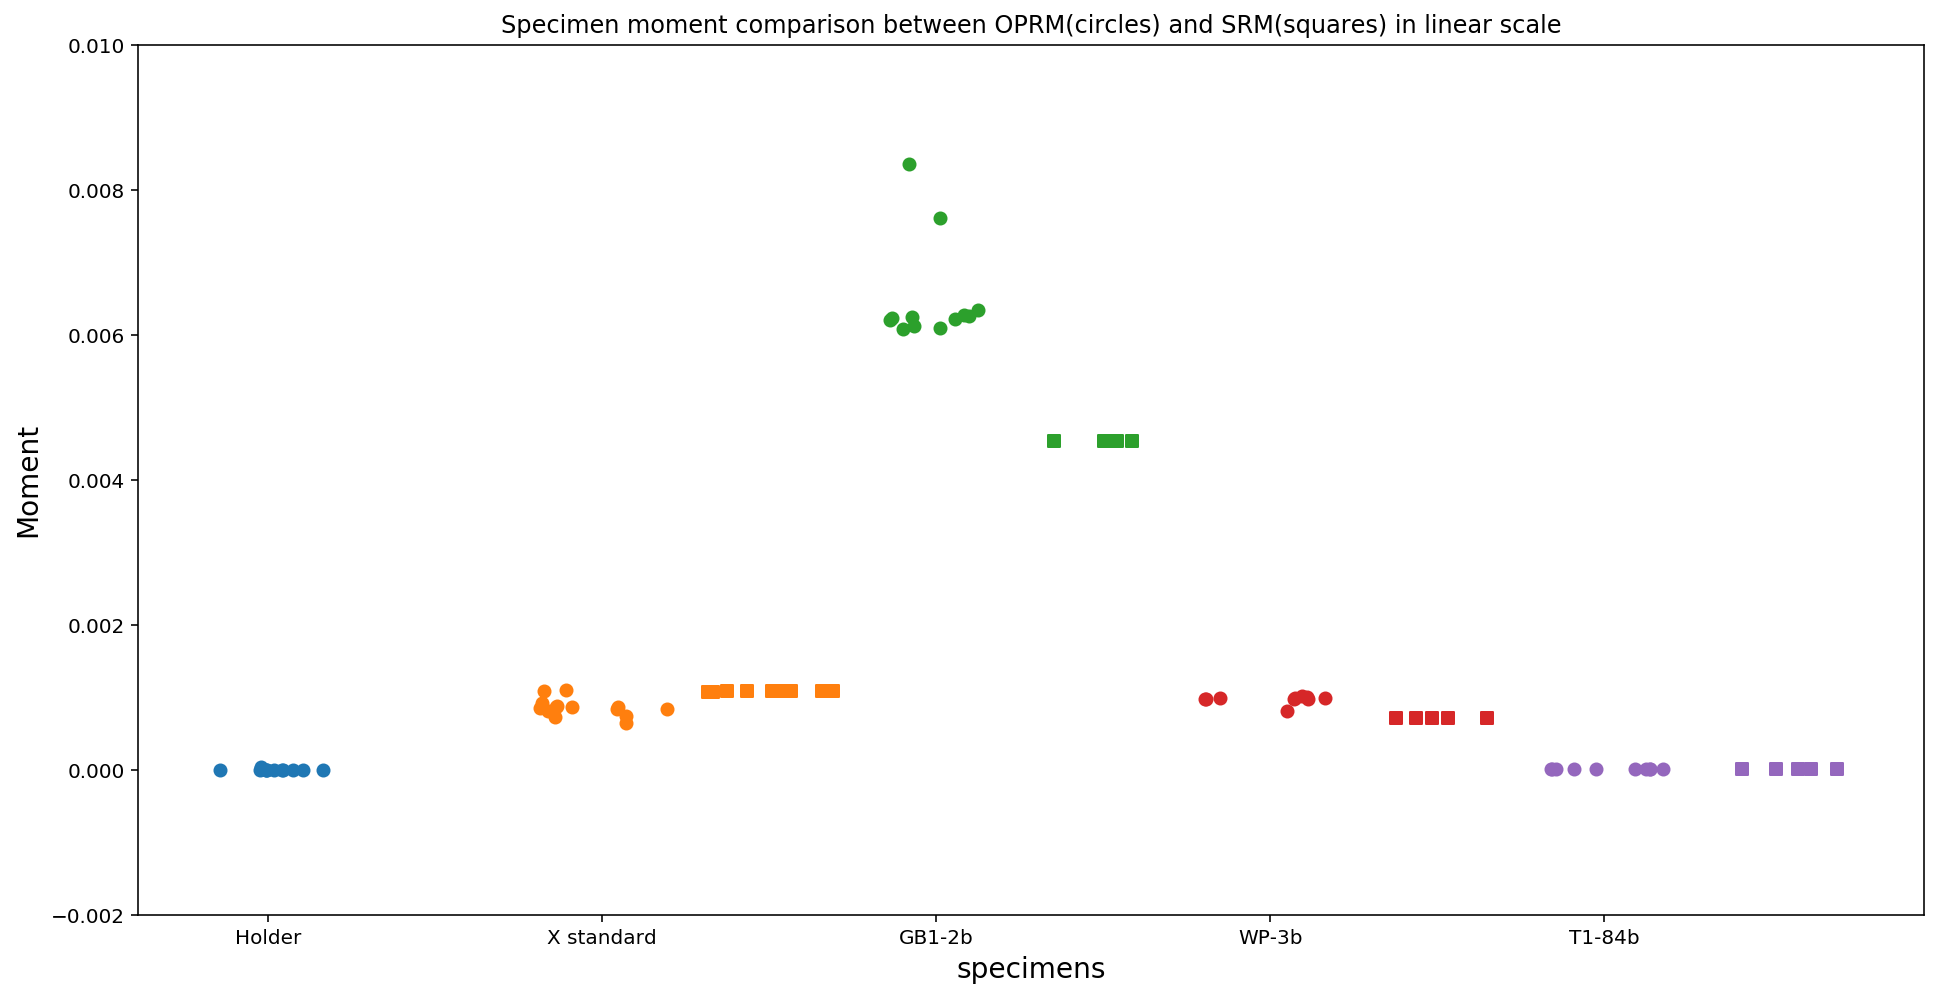

In [159]:

c1 = 'b'
c2 = 'r'
plt.figure(figsize=(16,8))
def stripplot(list_of_list, shift=0, random=False, marker='o', label=None):

    for i in range(len(list_of_list)):
        for j in list_of_list[i]:
            if random:
                plt.scatter(i+shift+np.random.uniform(-0.2,0.2), j, color = 'C'+str(i), marker = marker, label = label)
            else:
                plt.scatter(i+shift, j, color = 'C'+str(i), marker = marker, label = label)

                   
stripplot([Holder_OPRM['M'], X_OPRM['M'], GB1_2b_OPRM['M'], WP_3b_OPRM['M'], T1_84b_OPRM['M']], random = True, label = 'OPRM measurements')  
stripplot([[], X_SRM_DF['Ms'], GB1_2b_SRM_DF['Ms'], WP_3b_SRM_DF['Ms'], T1_84b_SRM_DF['Ms']], random = True, 
          shift = 0.5, marker = 's', label = 'SM measurements')
# sns.stripplot([Holder_OPRM['M'], X_OPRM['M'], GB1_2b_OPRM['M'], WP_3b_OPRM['M'], T1_84b_OPRM['M']], positions=[1,2,3,4,5], notch=True, patch_artist=True,
#             boxprops=dict(facecolor=c1, color=c1),
#             capprops=dict(color=c1),
#             whiskerprops=dict(color=c1),
#             flierprops=dict(color=c1, markeredgecolor=c1),
#             medianprops=dict(color=c1),
#             )
# sns.stripplot(Holder_OPRM['M'])
# sns.stripplot(X_OPRM['M'])
# sns.stripplot(GB1_2b_OPRM['M'])
# sns.stripplot(WP_3b_OPRM['M'])
# sns.stripplot(T1_84b_OPRM['M'])
# plt.boxplot([[], X_SRM_DF['Ms'], GB1_2b_SRM_DF['Ms'], WP_3b_SRM_DF['Ms'], T1_84b_SRM_DF['Ms']], positions=[1.5,2.5,3.5,4.5,5.5],notch=True, patch_artist=True,
#             boxprops=dict(facecolor=c2, color=c2),
#             capprops=dict(color=c2),
#             whiskerprops=dict(color=c2),
#             flierprops=dict(color=c2, markeredgecolor=c2),
#             medianprops=dict(color=c2),
#             )

# plt.xticks([1,2,3,4,5], ['Holder', 'X standard', 'GB1-2b', 'WP-3b', 'T1-84b'])
plt.ylabel('Moment', fontdict={'fontsize':14})
# plt.yscale('log')
plt.ylim(-0.002, 1e-2)
plt.xlabel('specimens', fontdict={'fontsize':14})
plt.xticks([0,1,2,3,4], ['Holder', 'X standard', 'GB1-2b', 'WP-3b', 'T1-84b'])
plt.title('Specimen moment comparison between OPRM(circles) and SRM(squares) in linear scale')
# plt.legend()
plt.savefig('Figures/Moment_comparison.pdf')
plt.show()

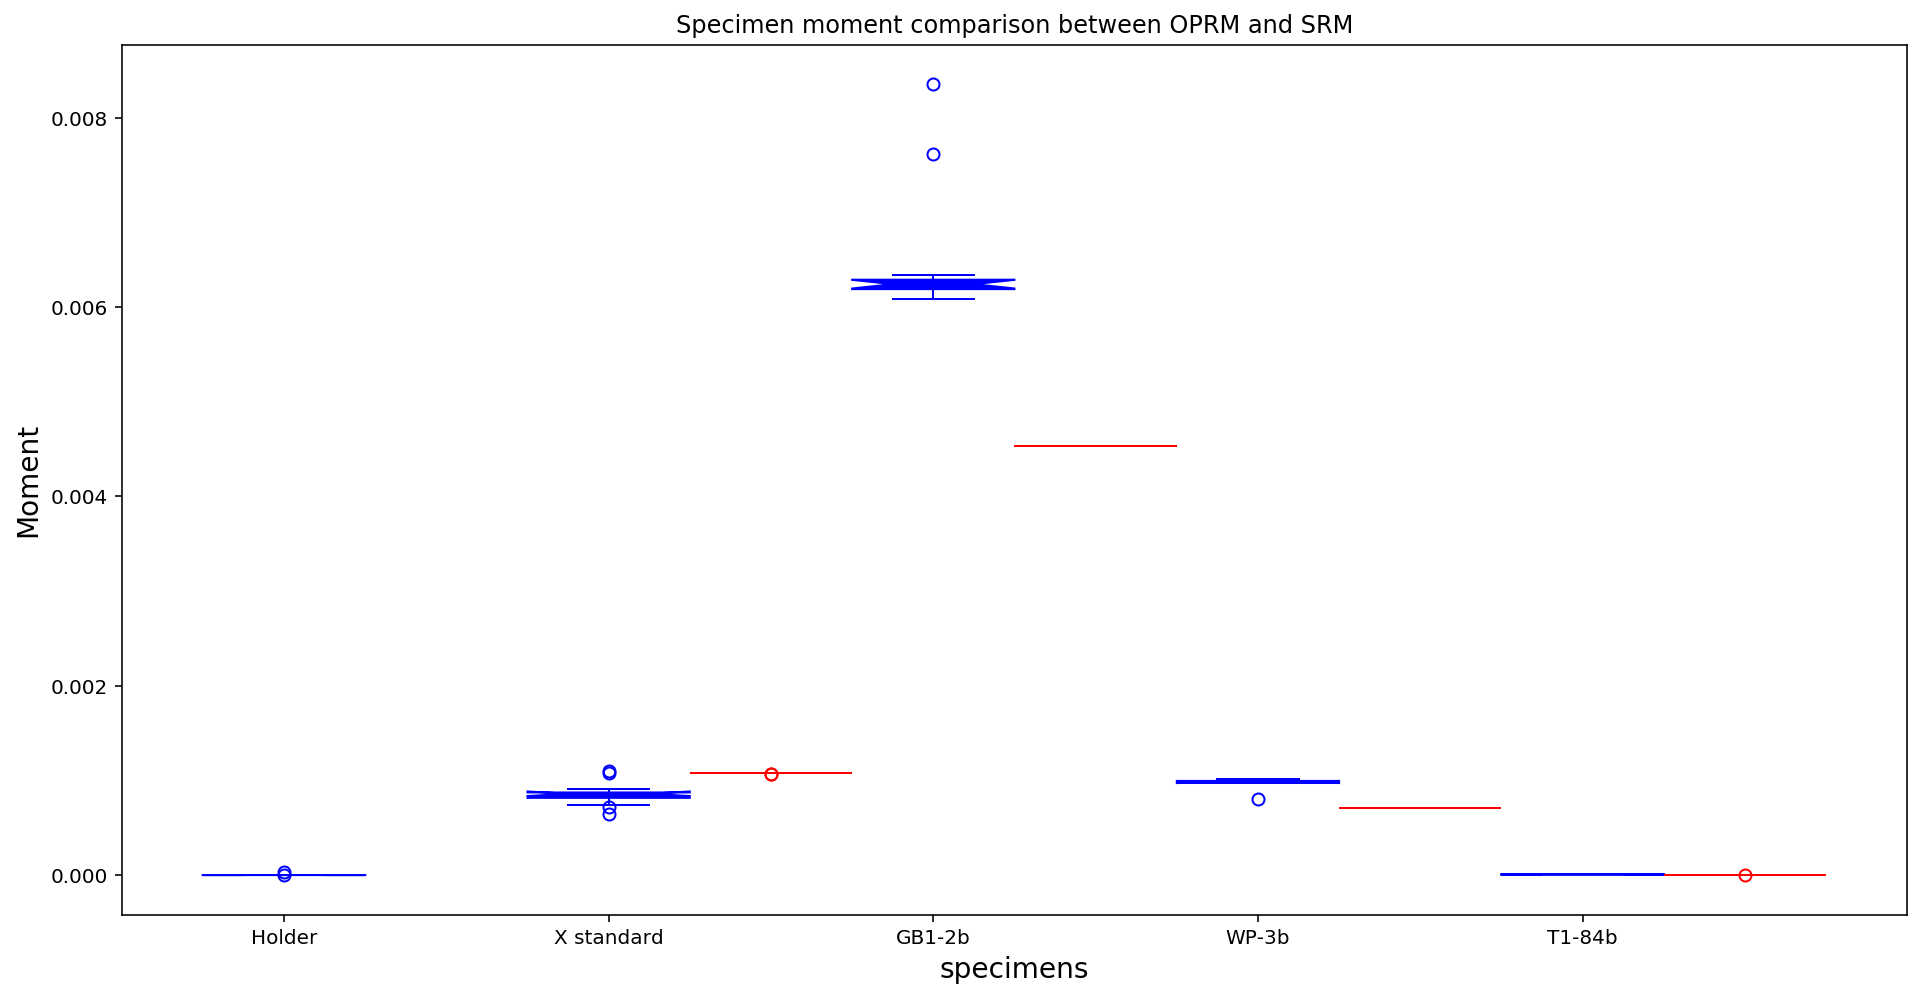

In [153]:
plt.figure(figsize=(16,8))
c1 = 'b'
c2 = 'r'
plt.boxplot([Holder_OPRM['M'], X_OPRM['M'], GB1_2b_OPRM['M'], WP_3b_OPRM['M'], T1_84b_OPRM['M']], positions=[1,2,3,4,5], notch=True, patch_artist=True,
            boxprops=dict(facecolor=c1, color=c1),
            capprops=dict(color=c1),
            whiskerprops=dict(color=c1),
            flierprops=dict(color=c1, markeredgecolor=c1),
            medianprops=dict(color=c1),
            )

plt.boxplot([[], X_SRM_DF['Ms'], GB1_2b_SRM_DF['Ms'], WP_3b_SRM_DF['Ms'], T1_84b_SRM_DF['Ms']], positions=[1.5,2.5,3.5,4.5,5.5],notch=True, patch_artist=True,
            boxprops=dict(facecolor=c2, color=c2),
            capprops=dict(color=c2),
            whiskerprops=dict(color=c2),
            flierprops=dict(color=c2, markeredgecolor=c2),
            medianprops=dict(color=c2),
            )

plt.xticks([1,2,3,4,5], ['Holder', 'X standard', 'GB1-2b', 'WP-3b', 'T1-84b'])
plt.ylabel('Moment', fontdict={'fontsize':14})
# plt.yscale('log')
plt.xlabel('specimens', fontdict={'fontsize':14})
plt.title('Specimen moment comparison between OPRM and SRM')
plt.savefig('Figures/Moment_comparison.pdf')
plt.show()

In [40]:
pmag.dir_df_fisher_mean??

Signature: pmag.dir_df_fisher_mean(dir_df)
Source:   
def dir_df_fisher_mean(dir_df):
    """
    calculates fisher mean for Pandas data frame

    Parameters
    __________
    dir_df: pandas data frame with columns:
        dir_dec : declination
        dir_inc : inclination
    Returns
    -------
    fpars : dictionary containing the Fisher mean and statistics
        dec : mean declination
        inc : mean inclination
        r : resultant vector length
        n : number of data points
        k : Fisher k value
        csd : Fisher circular standard deviation
        alpha95 : Fisher circle of 95% confidence
    """
    N = dir_df.dir_dec.values.shape[0]  # number of data points
    fpars = {}
    if N < 2:
        return fpars
    dirs = dir_df[['dir_dec', 'dir_inc']].values
    X = dir2cart(dirs).transpose()
    Xbar = np.array([X[0].sum(), X[1].sum(), X[2].sum()])
    R = np.sqrt(Xbar[0]**2+Xbar[1]**2+Xbar[2]**2)
    Xbar = Xbar/R
    dir = cart2dir(Xbar)
    fpars["dec"] =

## Crystal Springs diabase test samples

### CS1-1a

In [63]:
CS1_1a_SRM_file = read_SRM_file('SRM_data/CS1-1')
CS1_1a_OPRM_file = read_OPRM_file('OPRM_data/CS1-1a.csv')

In [68]:
CS1_1a_SRM_file.head()

,step,dec,inc,Ms,blank,quality
0,,212.6,1.2,0.000420,,g
1,100,211.6,0.4,0.000413,,g
2,150,211.5,-0.0,0.000401,,g
3,200,214.0,-3.0,0.000332,,g
4,250,210.1,-4.0,0.000311,,g


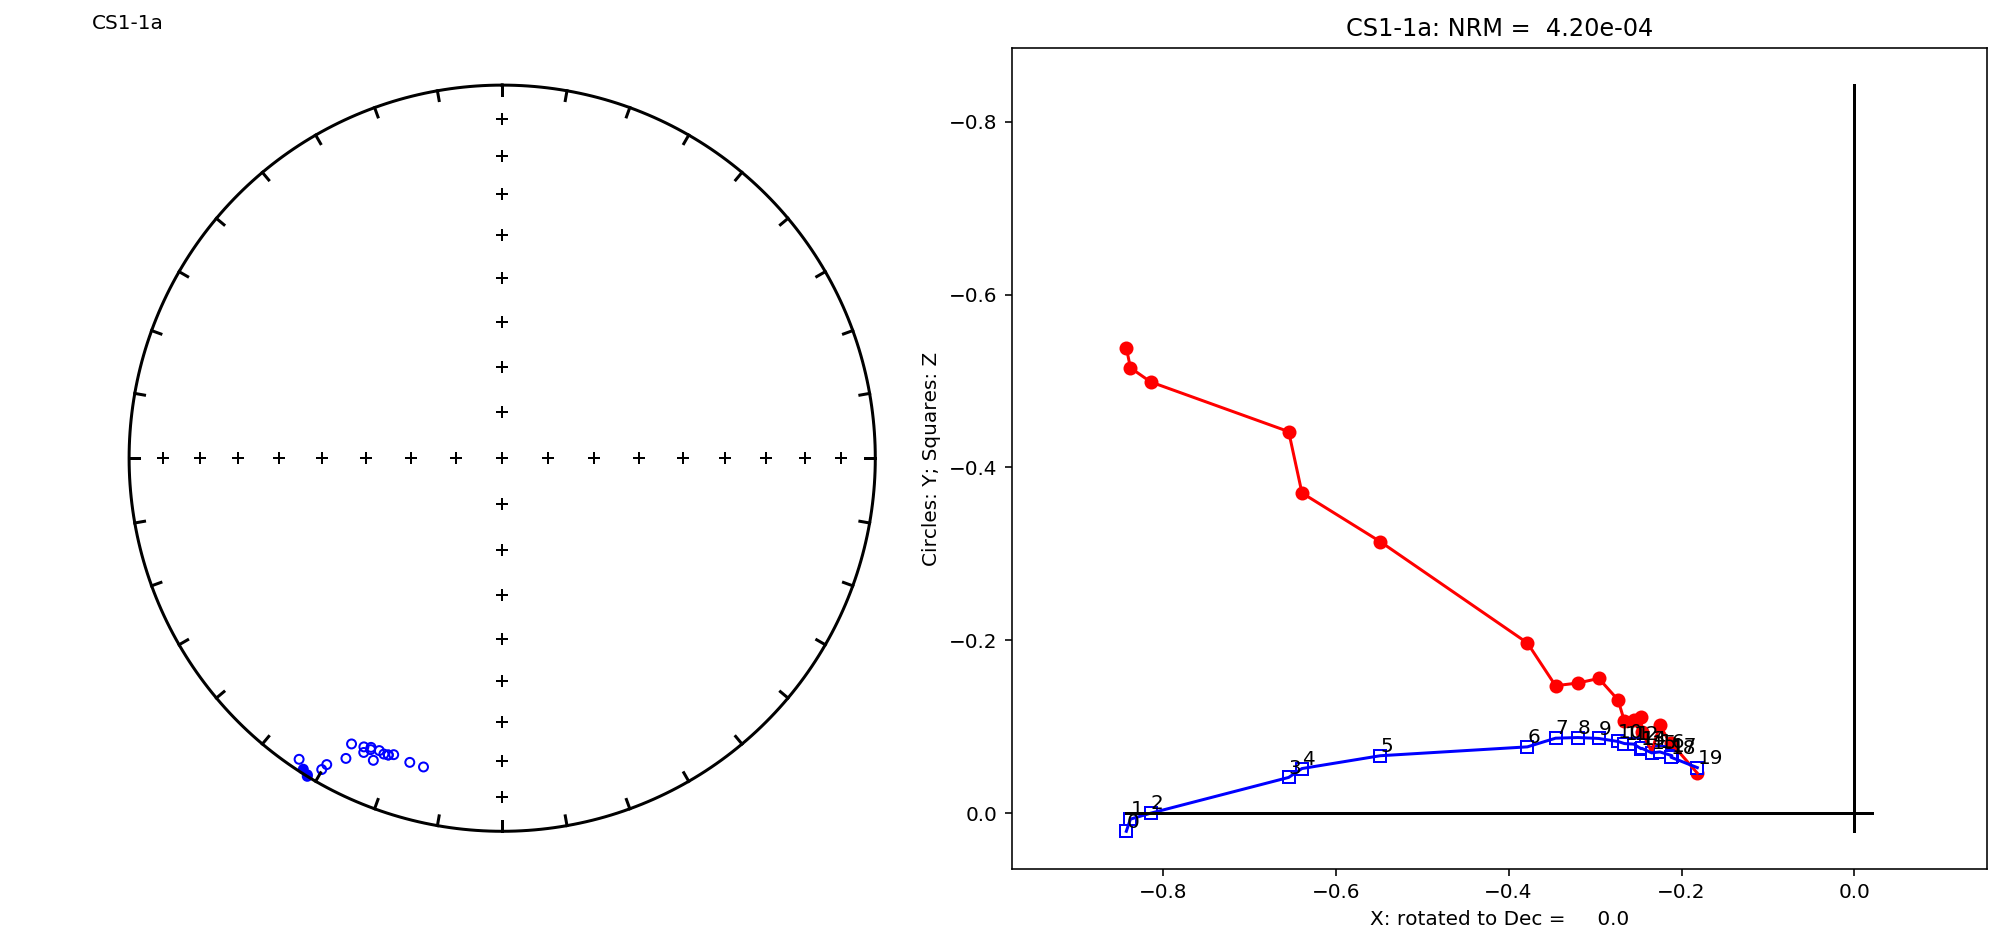

In [136]:
ZED={'eqarea':1,'zijd':2, 'demag':3}# make datablock
angle=0
units='emu'
fig=plt.figure(1, (14,6)) # make a figure
fig.add_subplot(121)
plot_eq(CS1_1a_SRM_file[['dec','inc']].values.tolist(), 'CS1-1a')
fig.add_subplot(122)
plot_zij(CS1_1a_SRM_file[['step','dec','inc','Ms','blank','quality']].values.tolist(),angle,'CS1-1a',units)

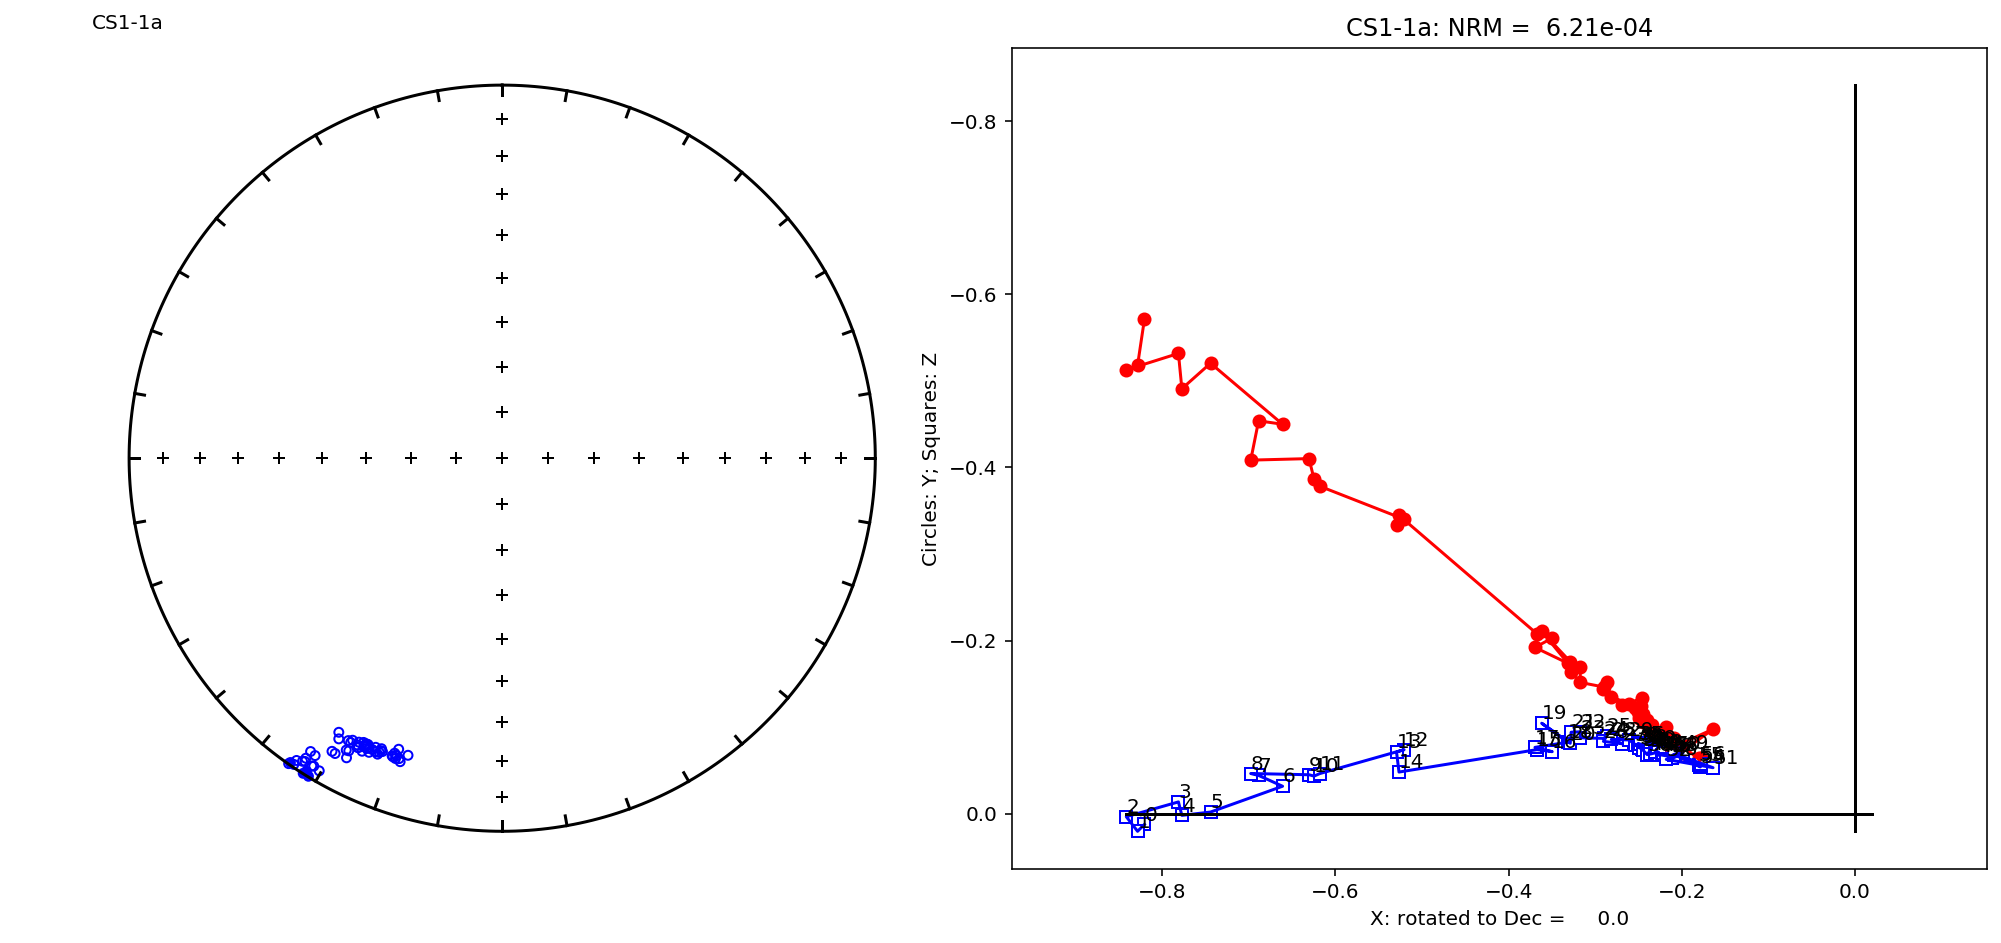

In [137]:
ZED={'eqarea':1,'zijd':2, 'demag':3}# make datablock
angle=0
units='emu'
fig=plt.figure(1, (14,6)) # make a figure
fig.add_subplot(121)
plot_eq(CS1_1a_OPRM_file[['dec','inc']].values.tolist(), 'CS1-1a')
fig.add_subplot(122)
plot_zij(CS1_1a_OPRM_file[['step','dec','inc','Ms','blank','quality']].values.tolist(),angle,'CS1-1a',units)

### CS2-1a

In [70]:
CS2_1a_SRM_file = read_SRM_file('SRM_data/CS2-1')
CS2_1a_OPRM_file = read_OPRM_file('OPRM_data/CS2-1a.csv')

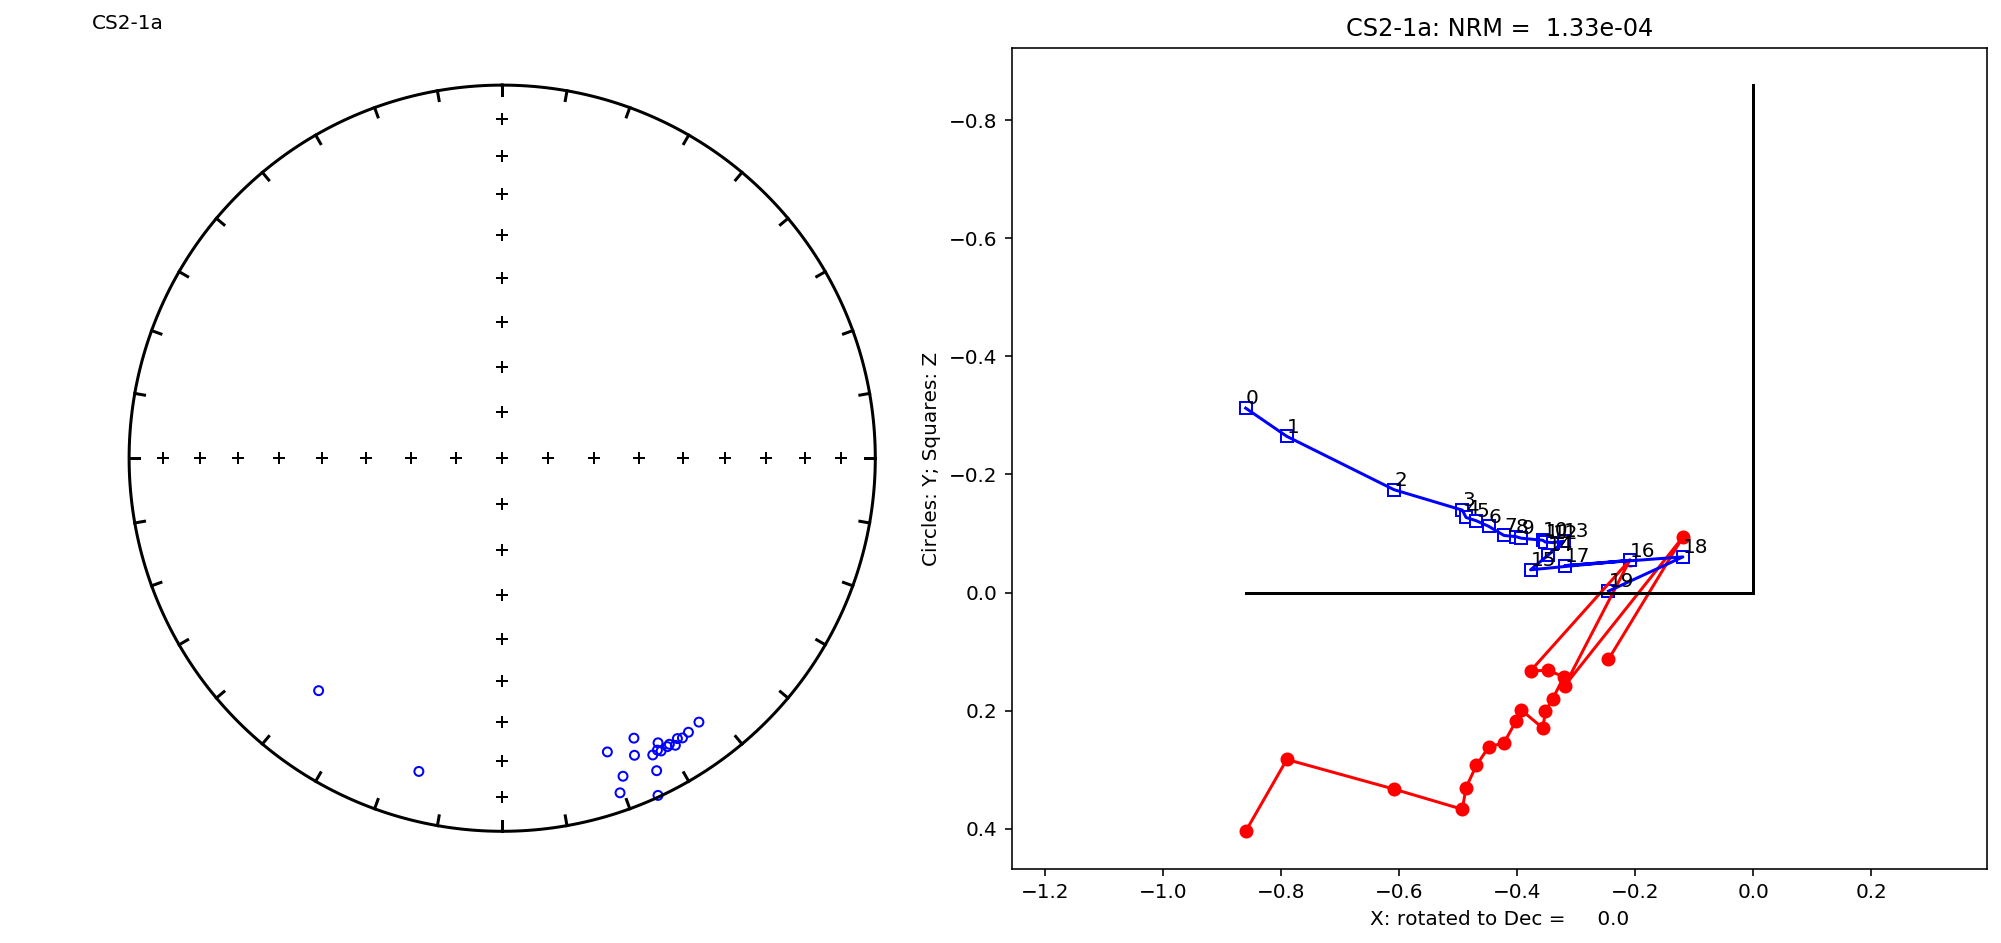

In [134]:
ZED={'eqarea':1,'zijd':2, 'demag':3}# make datablock
angle=0
units='emu'
fig=plt.figure(1, (14,6)) # make a figure
fig.add_subplot(121)
plot_eq(CS2_1a_SRM_file[['dec','inc']].values.tolist(), 'CS2-1a')
fig.add_subplot(122)
plot_zij(CS2_1a_SRM_file[['step','dec','inc','Ms','blank','quality']].values.tolist(),angle,'CS2-1a',units)

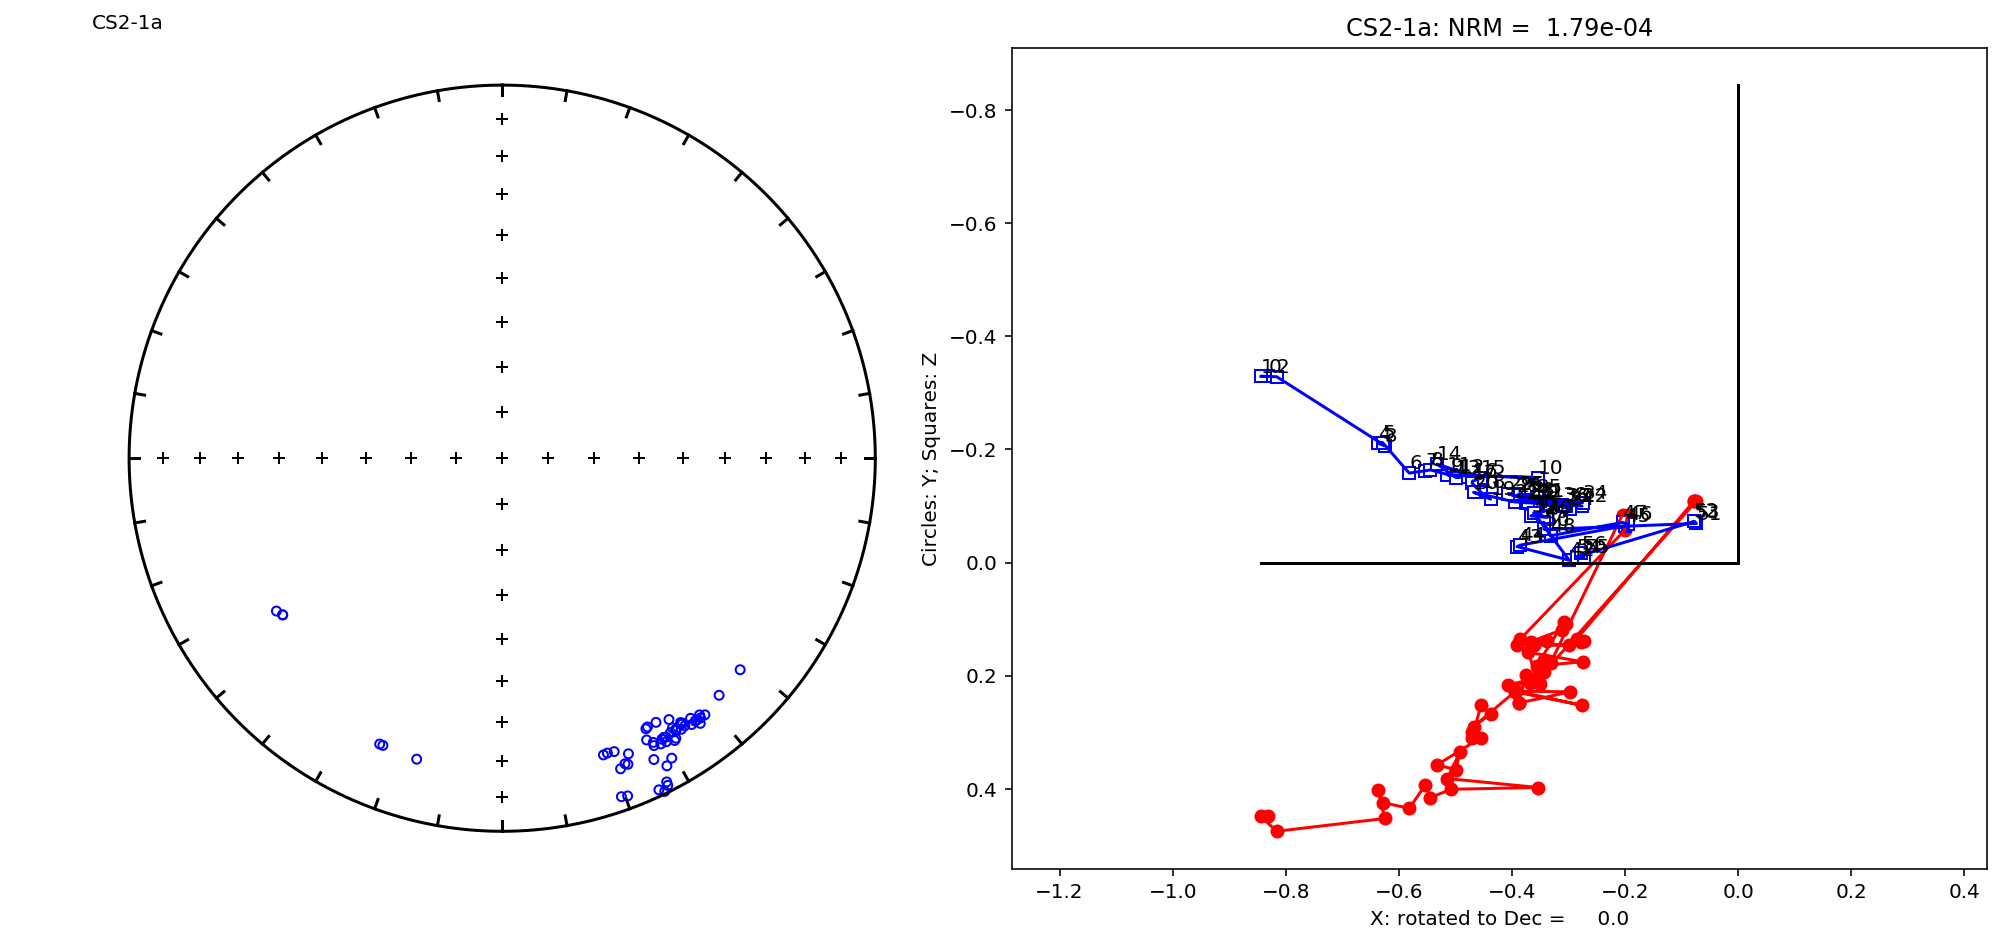

In [135]:
ZED={'eqarea':1,'zijd':2, 'demag':3}# make datablock
angle=0
units='emu'
fig=plt.figure(1, (14,6)) # make a figure
fig.add_subplot(121)
plot_eq(CS2_1a_OPRM_file[['dec','inc']].values.tolist(), 'CS2-1a')
fig.add_subplot(122)
plot_zij(CS2_1a_OPRM_file[['step','dec','inc','Ms','blank','quality']].values.tolist(),angle,'CS2-1a',units)

### CS3-1a

In [123]:
CS3_1a_SRM_file = read_SRM_file('SRM_data/CS3-1')
CS3_1a_OPRM_file = read_OPRM_file('OPRM_data/CS3-1a.csv')

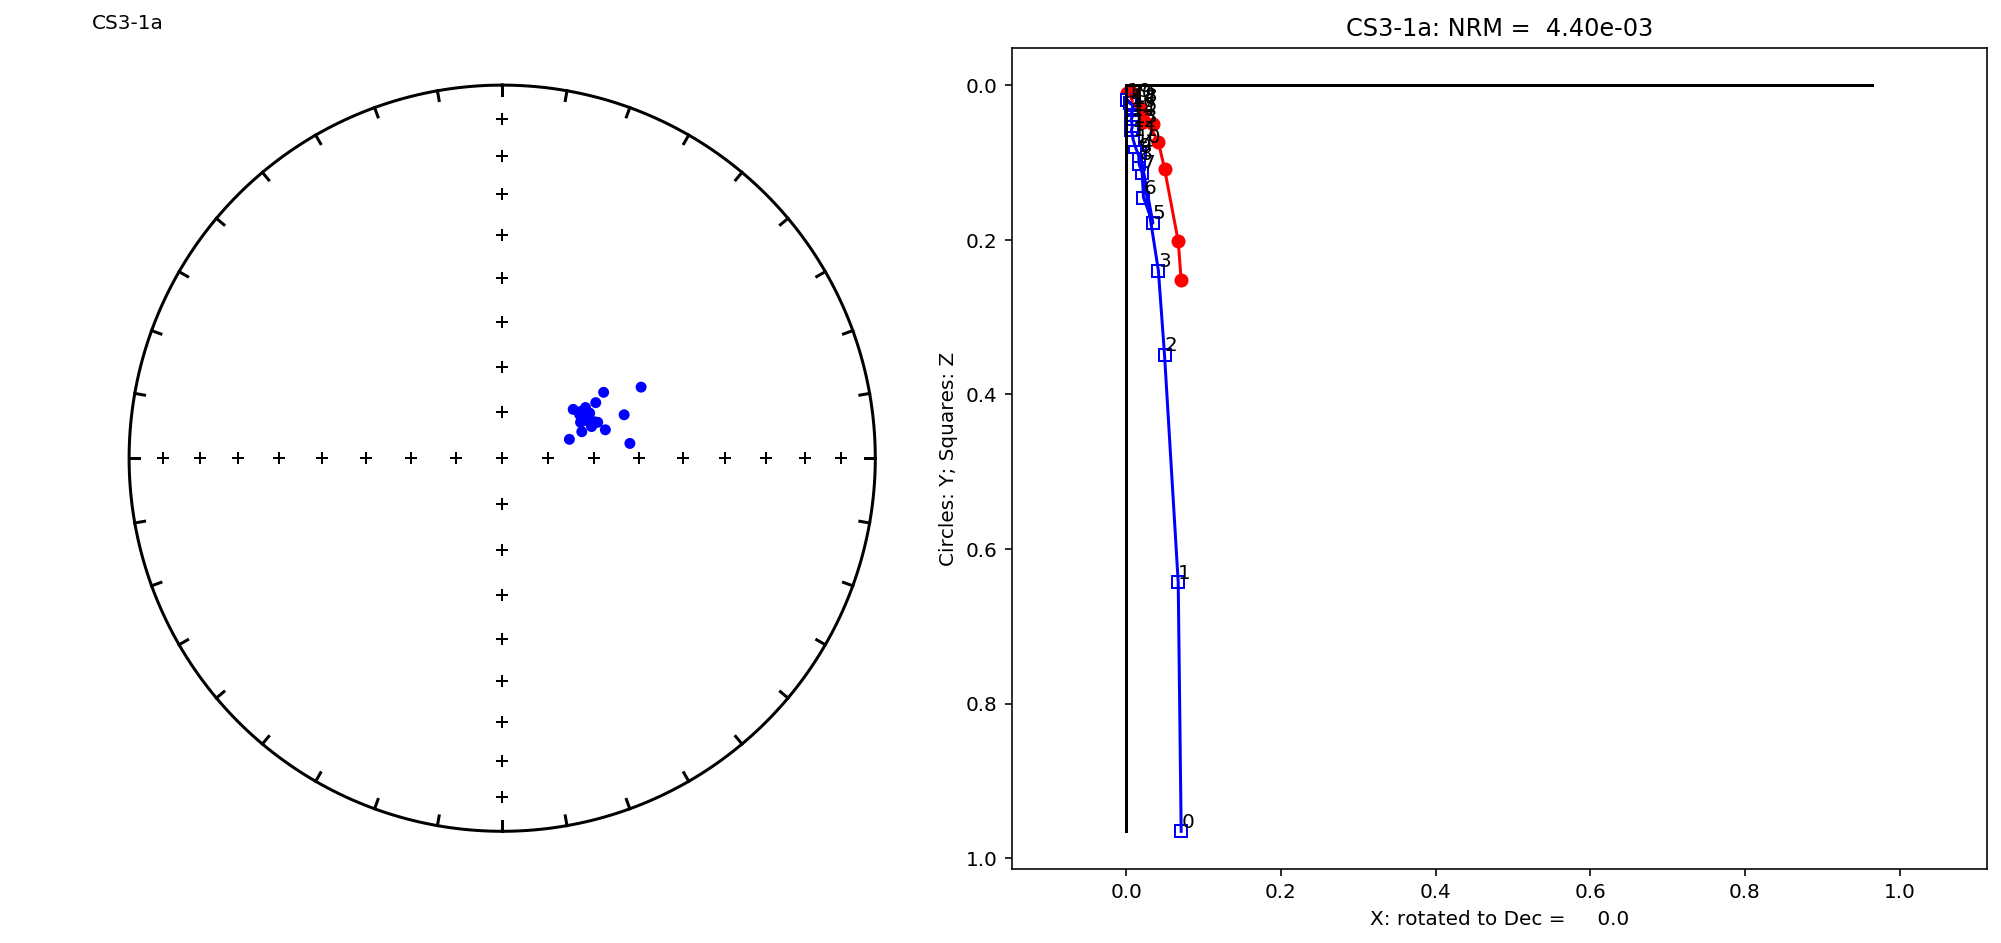

In [131]:
ZED={'eqarea':1,'zijd':2, 'demag':3}# make datablock
angle=0
units='emu'
fig=plt.figure(1, (14,6)) # make a figure
fig.add_subplot(121)
plot_eq(CS3_1a_SRM_file[['dec','inc']].values.tolist(), 'CS3-1a')
fig.add_subplot(122)
plot_zij(CS3_1a_SRM_file[['step','dec','inc','Ms','blank','quality']].values.tolist(),angle,'CS3-1a',units)

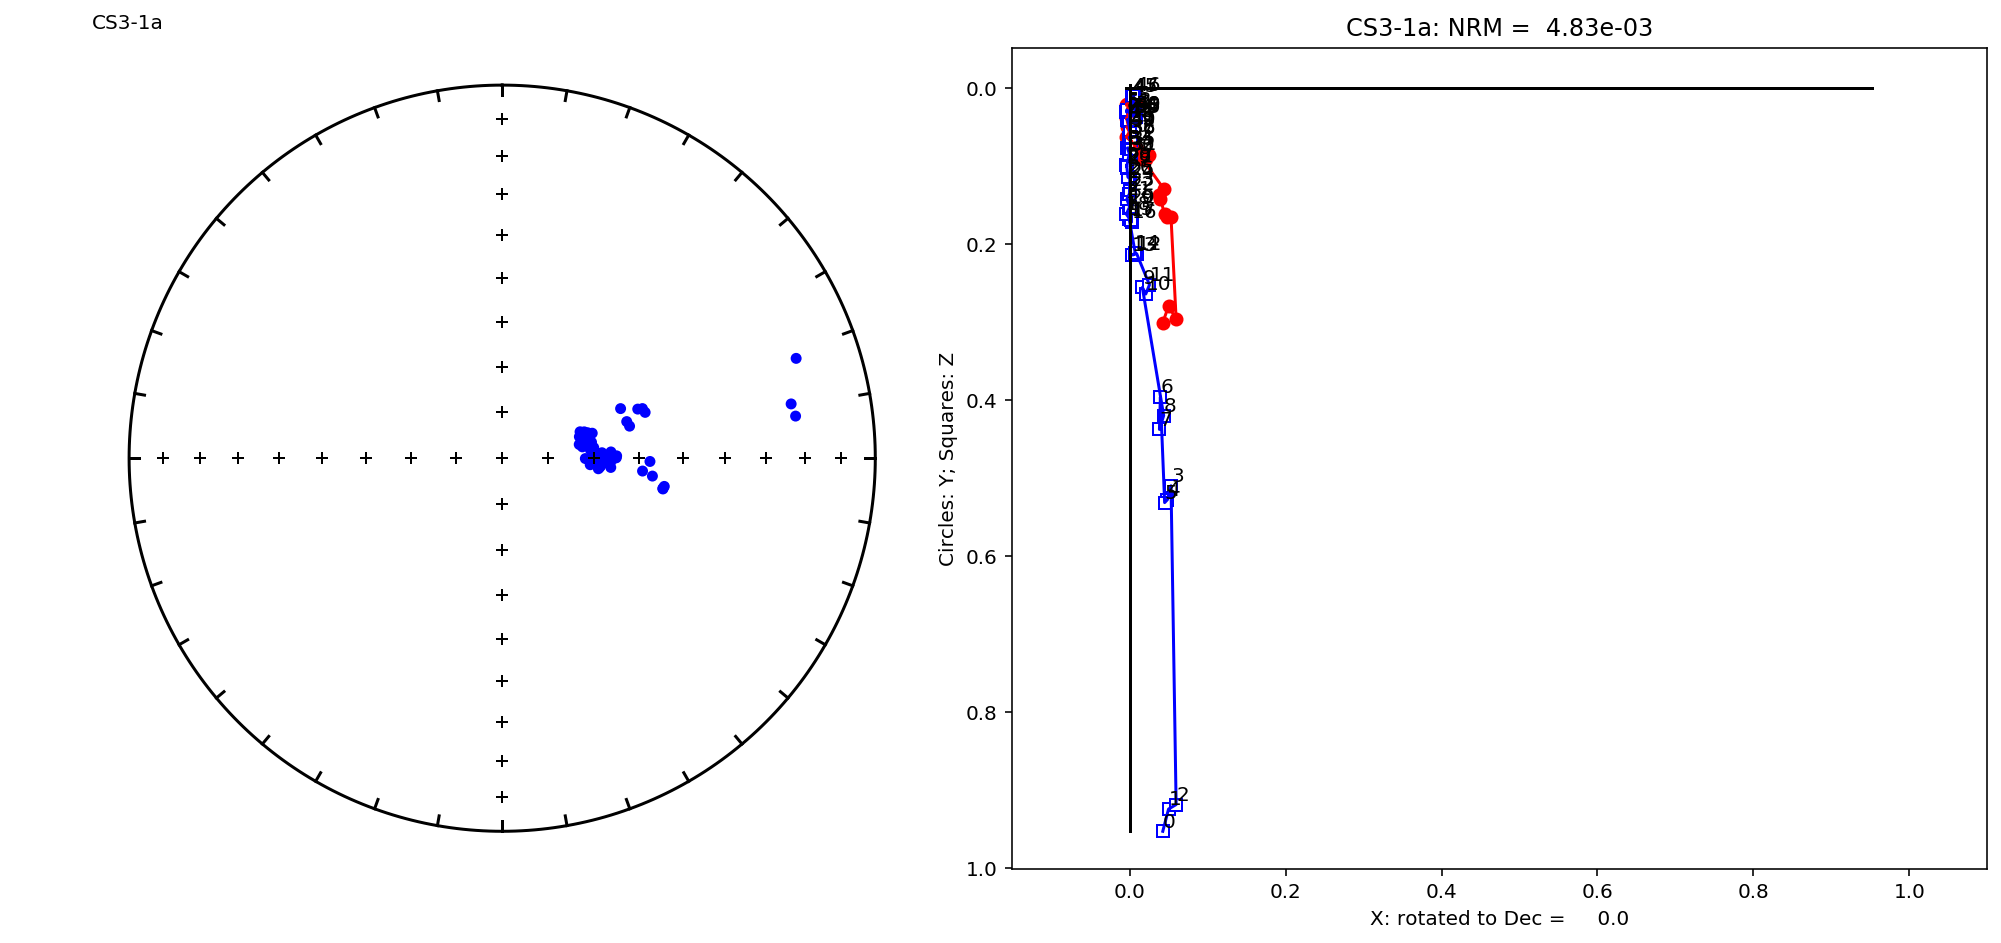

In [133]:
ZED={'eqarea':1,'zijd':2, 'demag':3}# make datablock
angle=0
units='emu'
fig=plt.figure(1, (14,6)) # make a figure
fig.add_subplot(121)
plot_eq(CS3_1a_OPRM_file[['dec','inc']].values.tolist(), 'CS3-1a')
fig.add_subplot(122)
plot_zij(CS3_1a_OPRM_file[['step','dec','inc','Ms','blank','quality']].values.tolist(),angle,'CS3-1a',units)

### CS7-1a

In [139]:
CS7_1a_SRM_file = read_SRM_file('SRM_data/CS7-1a')
CS7_1a_OPRM_file = read_OPRM_file('OPRM_data/CS7-1a.csv')

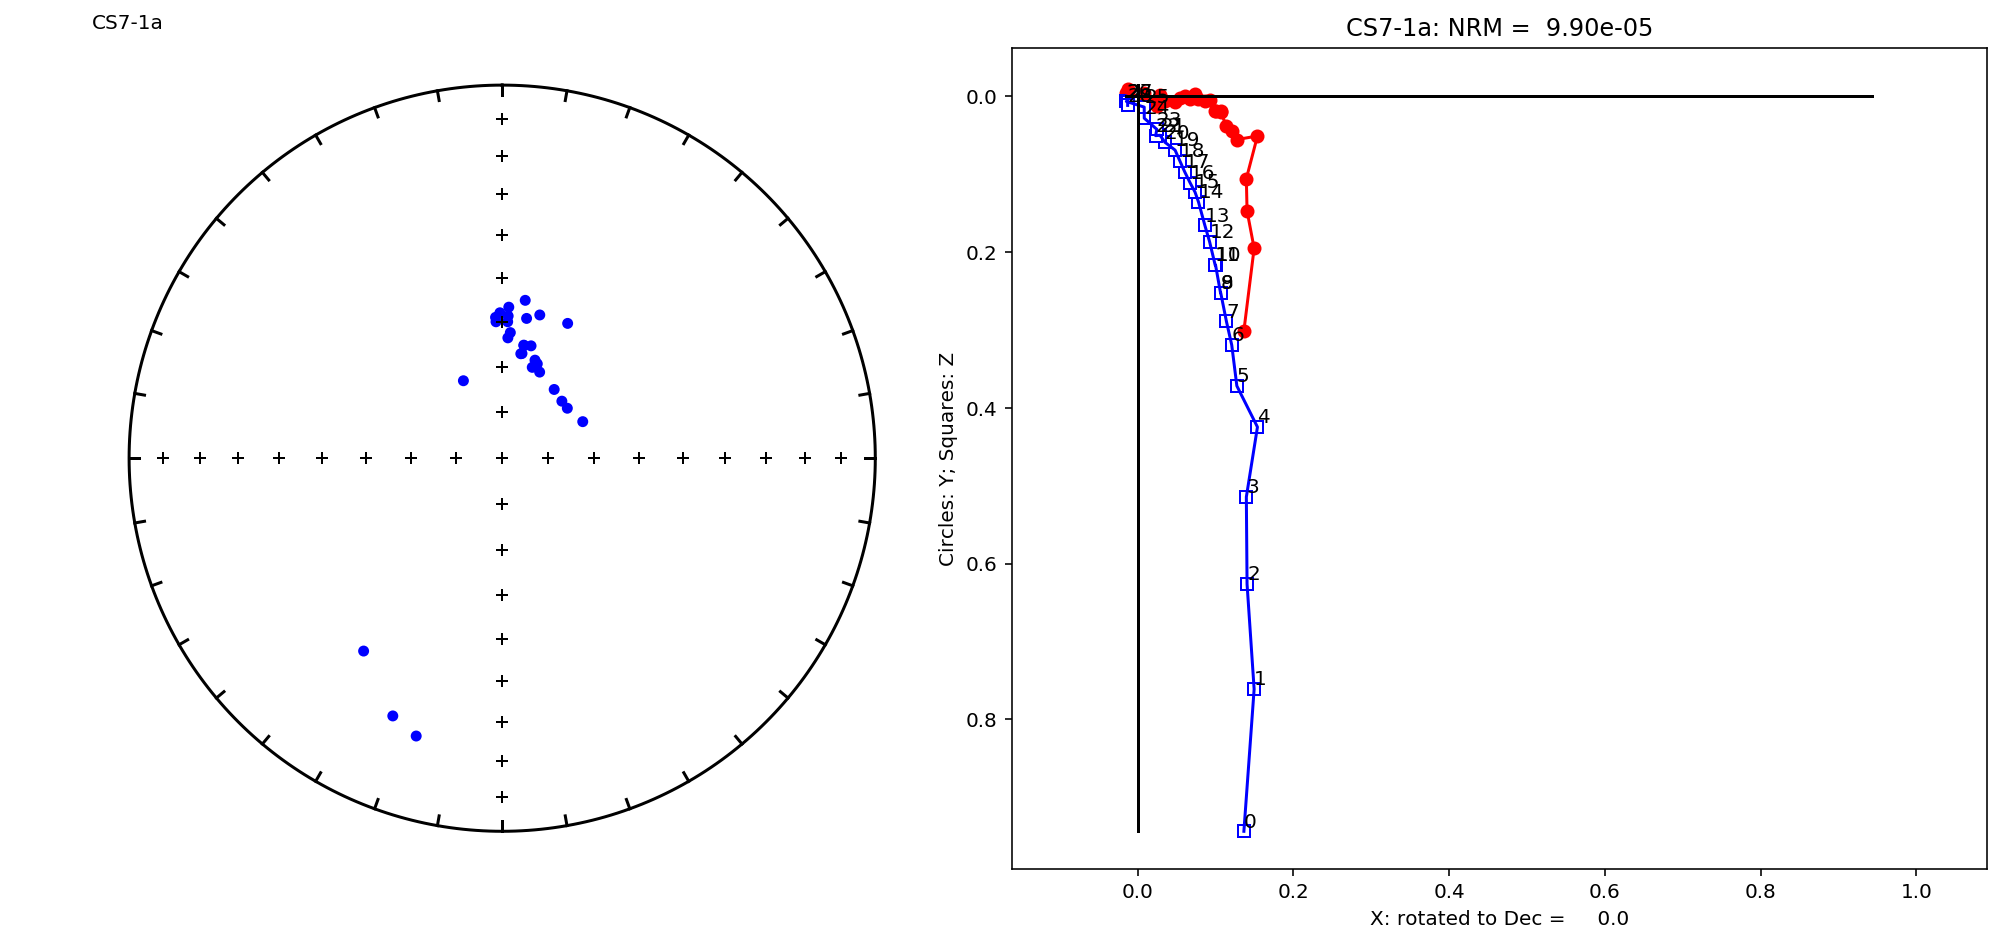

In [140]:
ZED={'eqarea':1,'zijd':2, 'demag':3}# make datablock
angle=0
units='emu'
fig=plt.figure(1, (14,6)) # make a figure
fig.add_subplot(121)
plot_eq(CS7_1a_SRM_file[['dec','inc']].values.tolist(), 'CS7-1a')
fig.add_subplot(122)
plot_zij(CS7_1a_SRM_file[['step','dec','inc','Ms','blank','quality']].values.tolist(),angle,'CS7-1a',units)

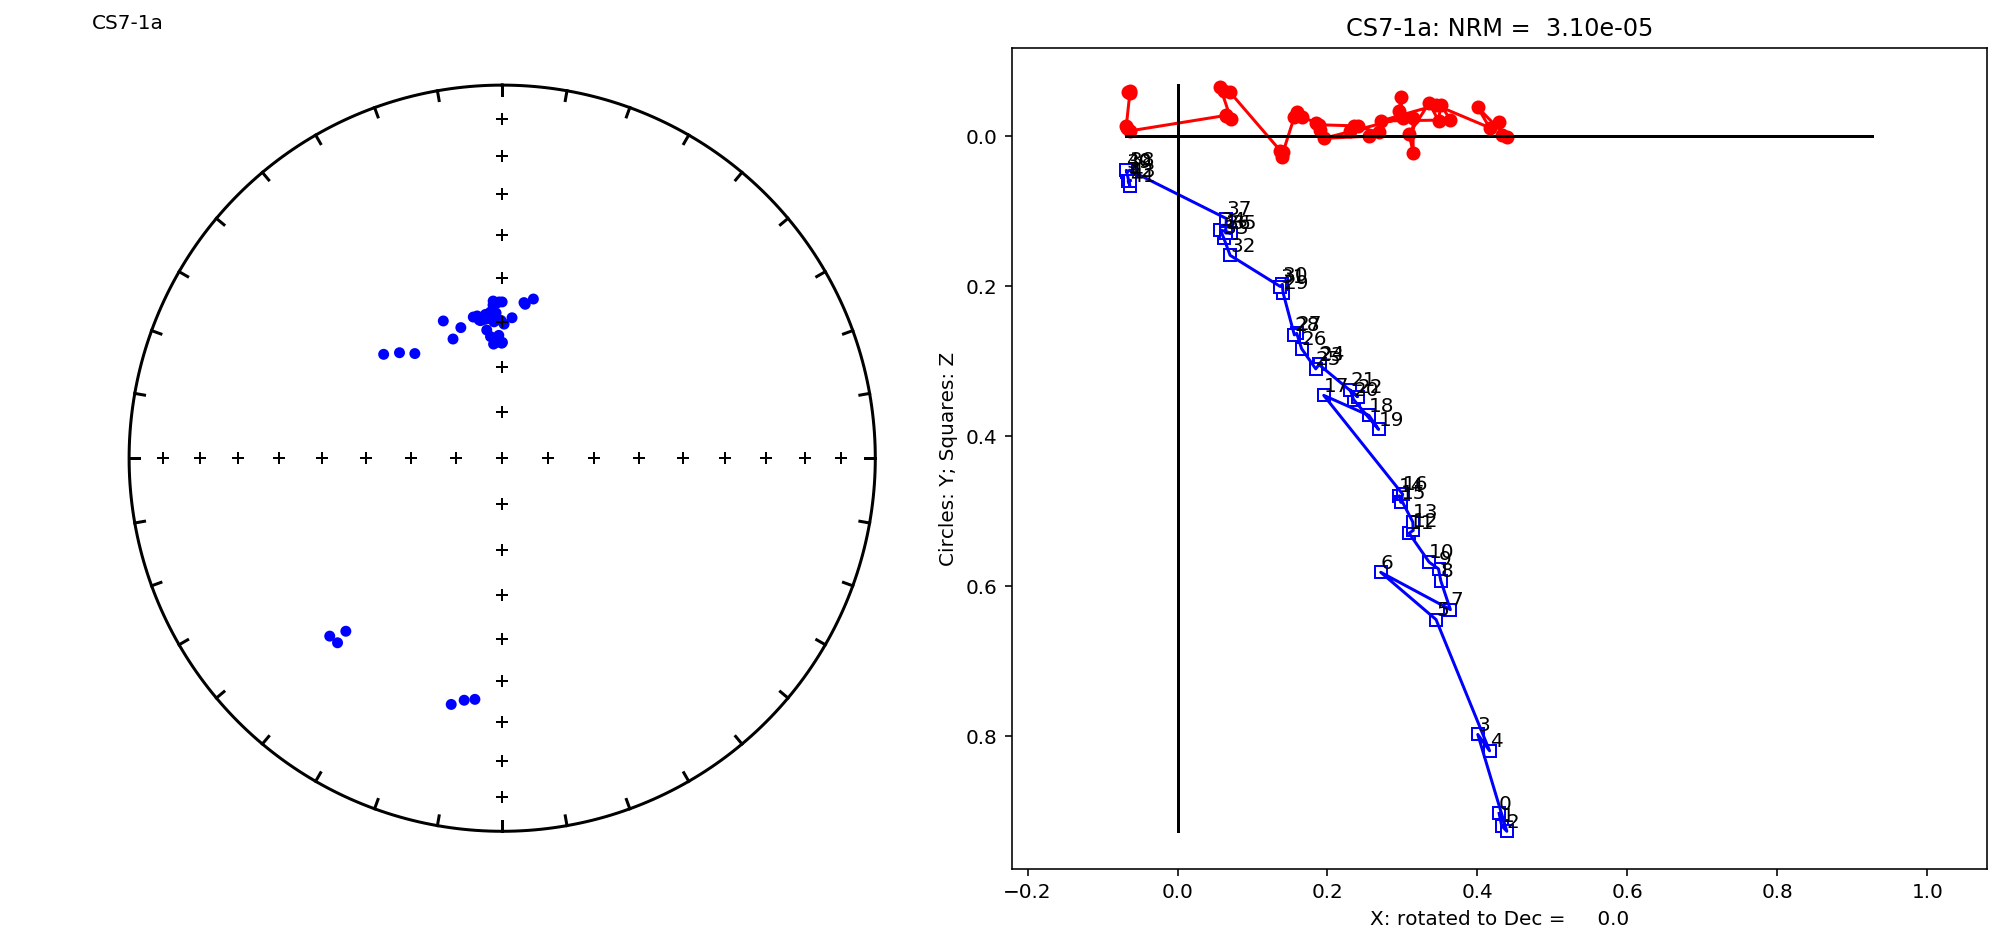

In [141]:
ZED={'eqarea':1,'zijd':2, 'demag':3}# make datablock
angle=0
units='emu'
fig=plt.figure(1, (14,6)) # make a figure
fig.add_subplot(121)
plot_eq(CS7_1a_OPRM_file[['dec','inc']].values.tolist(), 'CS7-1a')
fig.add_subplot(122)
plot_zij(CS7_1a_OPRM_file[['step','dec','inc','Ms','blank','quality']].values.tolist(),angle,'CS7-1a',units)

### CS8-1a

In [144]:
CS8_1a_SRM_file = read_SRM_file('SRM_data/CS8-1a')
CS8_1a_OPRM_file = read_OPRM_file('OPRM_data/CS8-1a.csv')

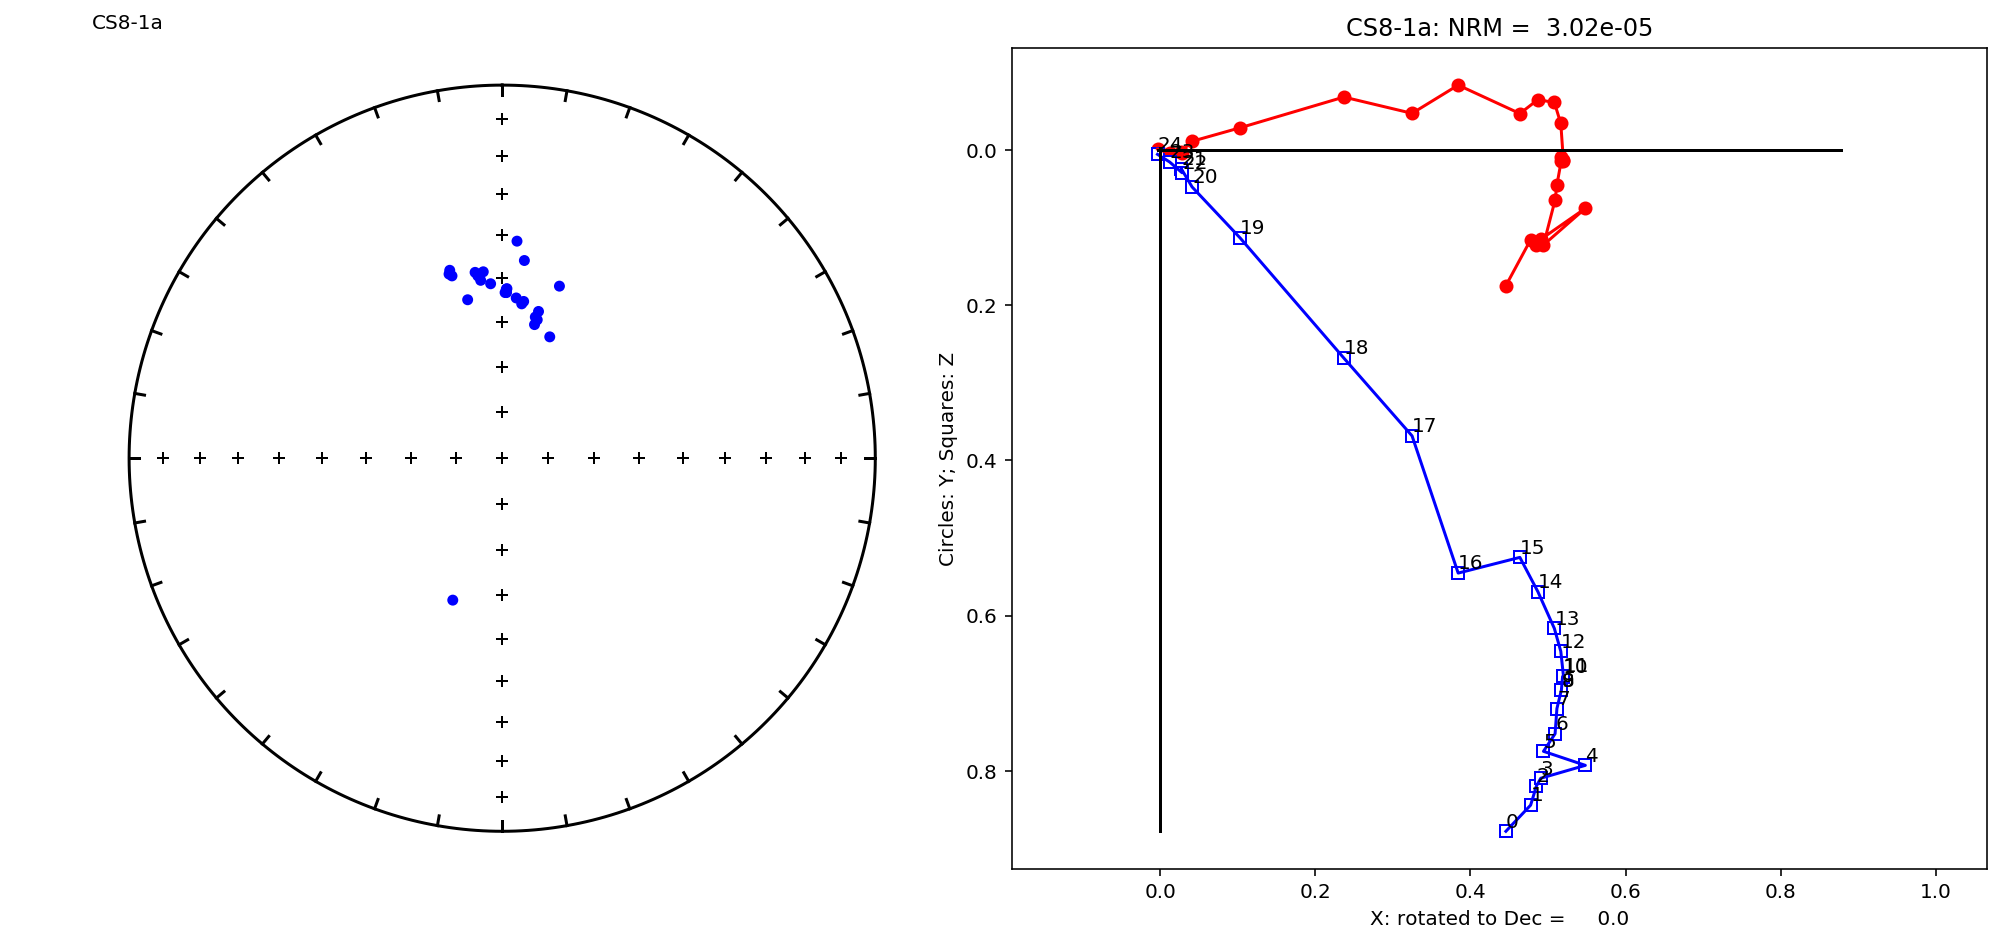

In [145]:
ZED={'eqarea':1,'zijd':2, 'demag':3}# make datablock
angle=0
units='emu'
fig=plt.figure(1, (14,6)) # make a figure
fig.add_subplot(121)
plot_eq(CS8_1a_SRM_file[['dec','inc']].values.tolist(), 'CS8-1a')
fig.add_subplot(122)
plot_zij(CS8_1a_SRM_file[['step','dec','inc','Ms','blank','quality']].values.tolist(),angle,'CS8-1a',units)

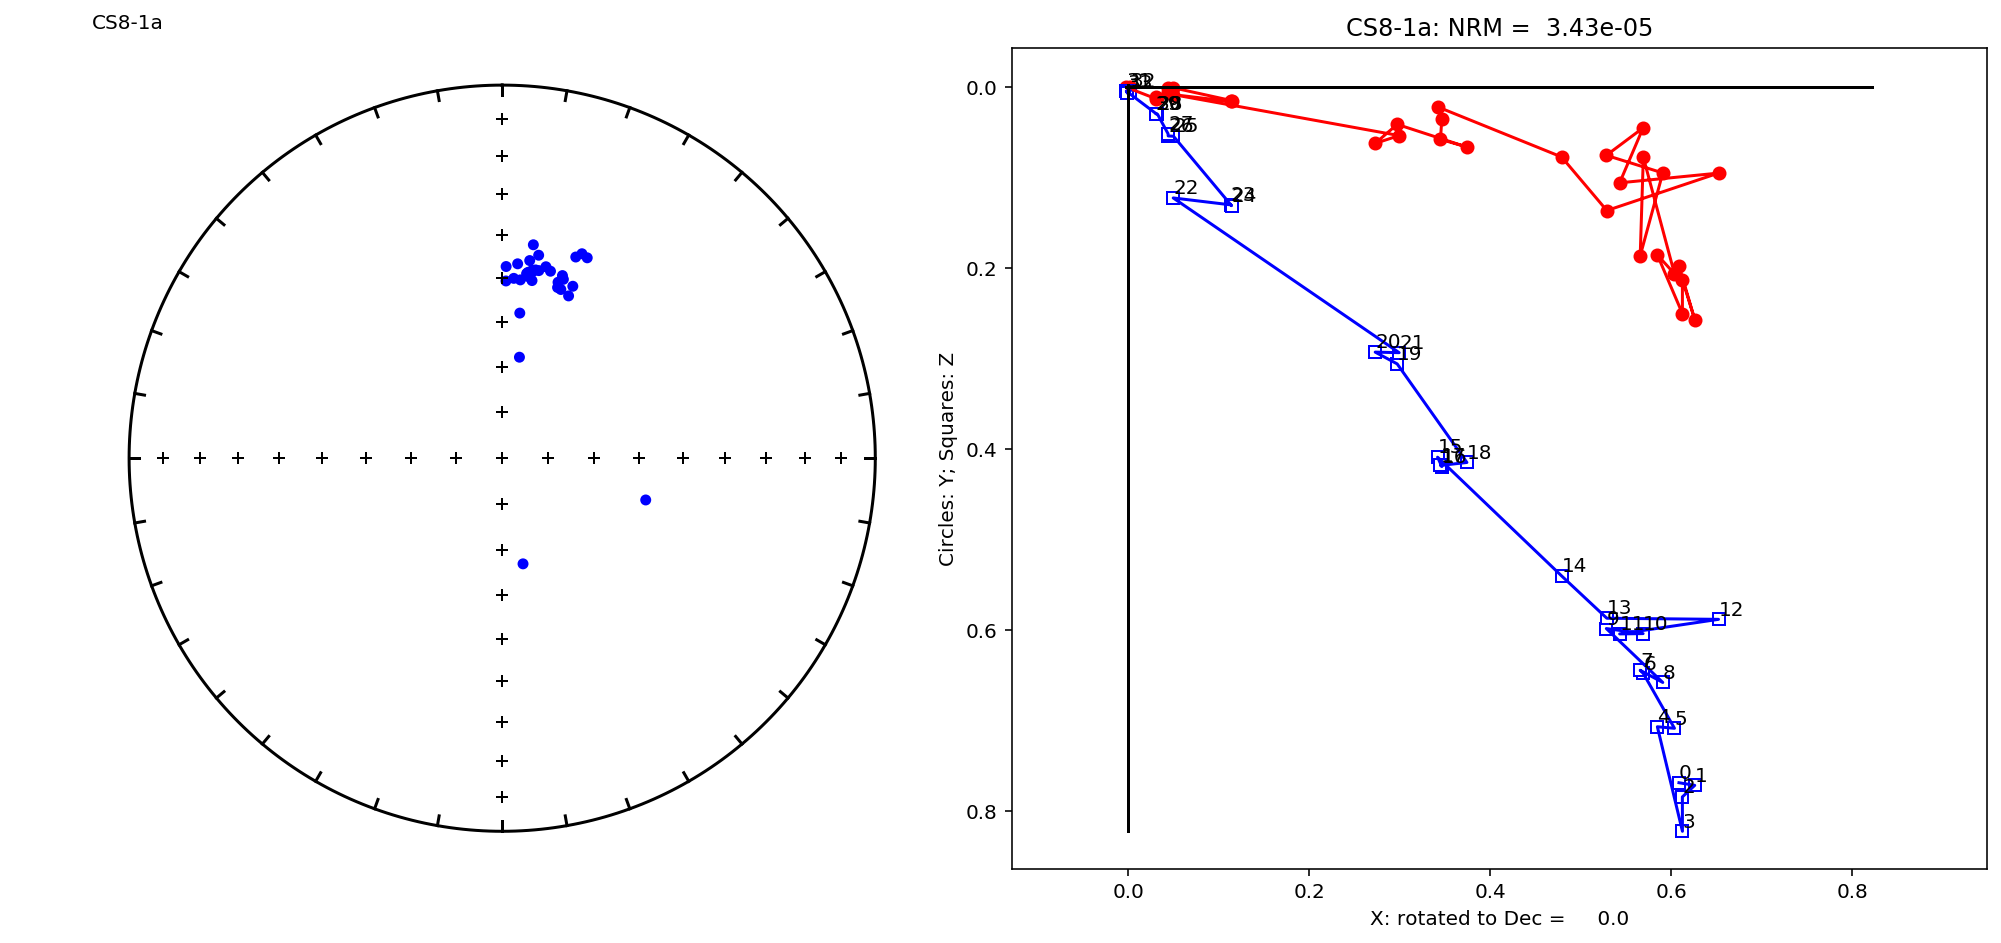

In [146]:
ZED={'eqarea':1,'zijd':2, 'demag':3}# make datablock
angle=0
units='emu'
fig=plt.figure(1, (14,6)) # make a figure
fig.add_subplot(121)
plot_eq(CS8_1a_OPRM_file[['dec','inc']].values.tolist(), 'CS8-1a')
fig.add_subplot(122)
plot_zij(CS8_1a_OPRM_file[['step','dec','inc','Ms','blank','quality']].values.tolist(),angle,'CS8-1a',units)

### CS9-1a

In [148]:
CS9_1a_SRM_file = read_SRM_file('SRM_data/CS9-1a')
CS9_1a_OPRM_file = read_OPRM_file('OPRM_data/CS9-1a.csv')

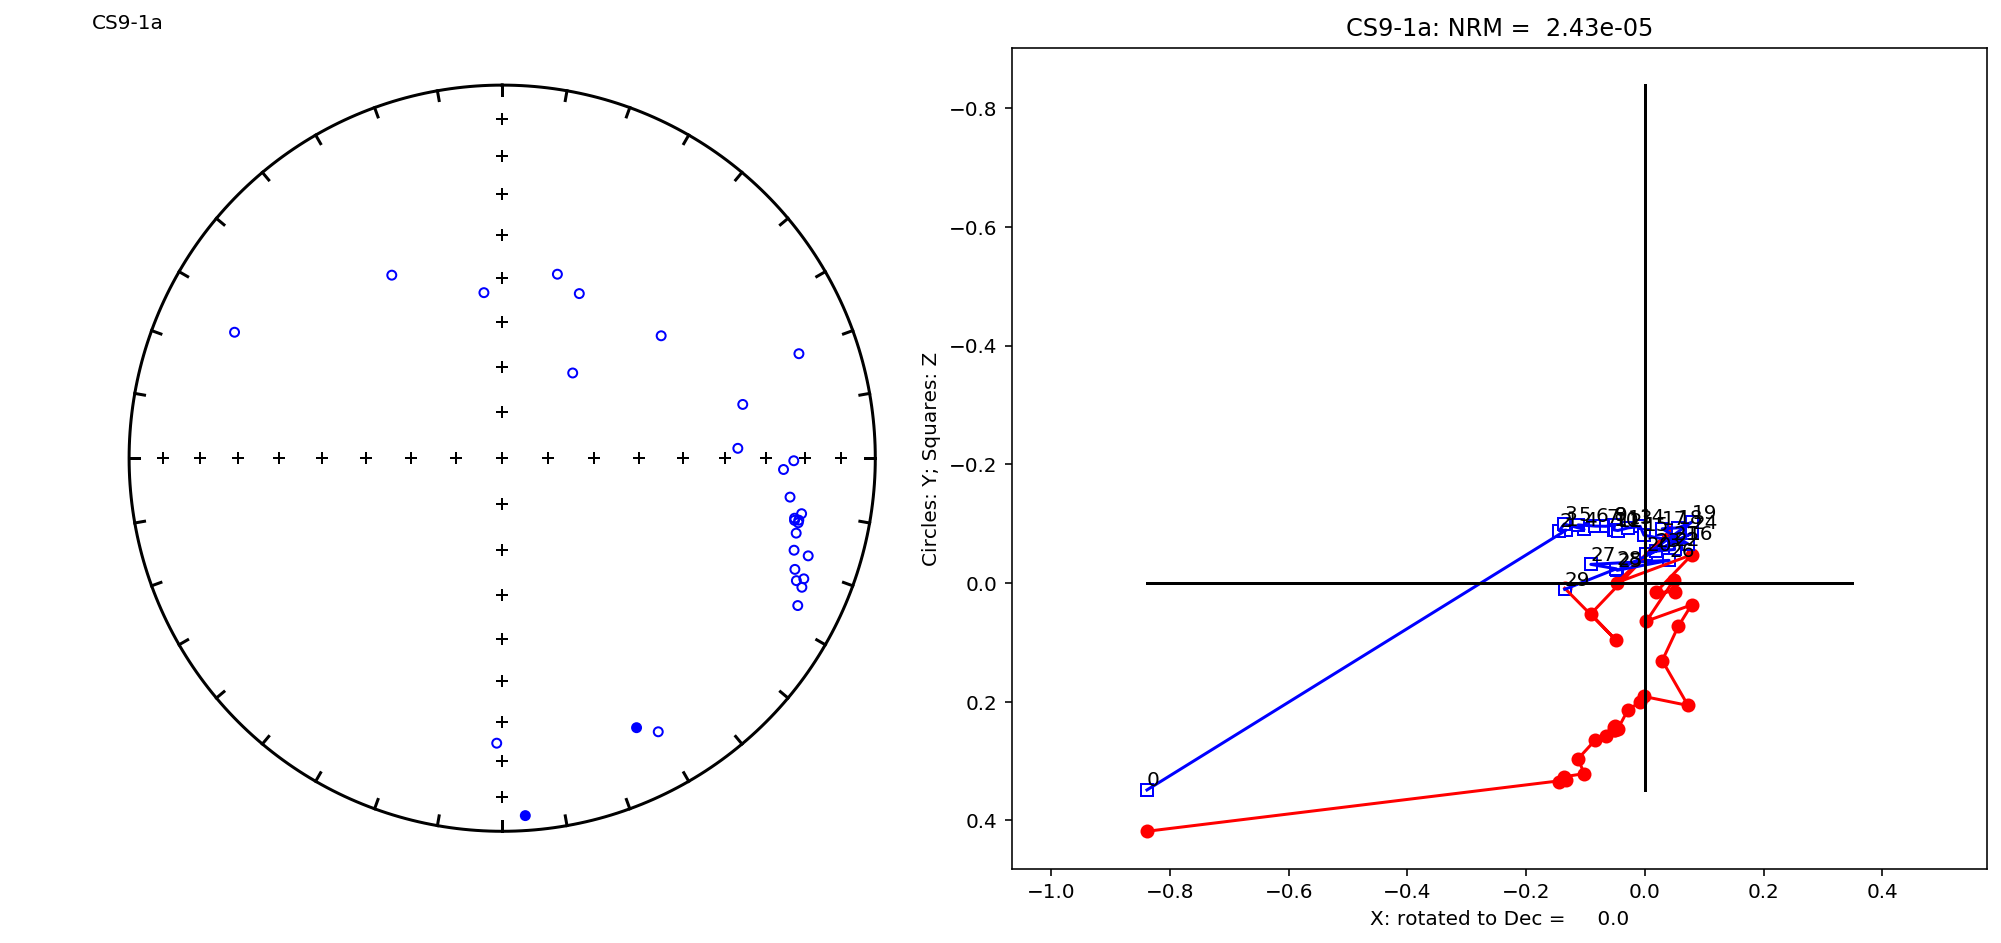

In [149]:
ZED={'eqarea':1,'zijd':2, 'demag':3}# make datablock
angle=0
units='emu'
fig=plt.figure(1, (14,6)) # make a figure
fig.add_subplot(121)
plot_eq(CS9_1a_SRM_file[['dec','inc']].values.tolist(), 'CS9-1a')
fig.add_subplot(122)
plot_zij(CS9_1a_SRM_file[['step','dec','inc','Ms','blank','quality']].values.tolist(),angle,'CS9-1a',units)

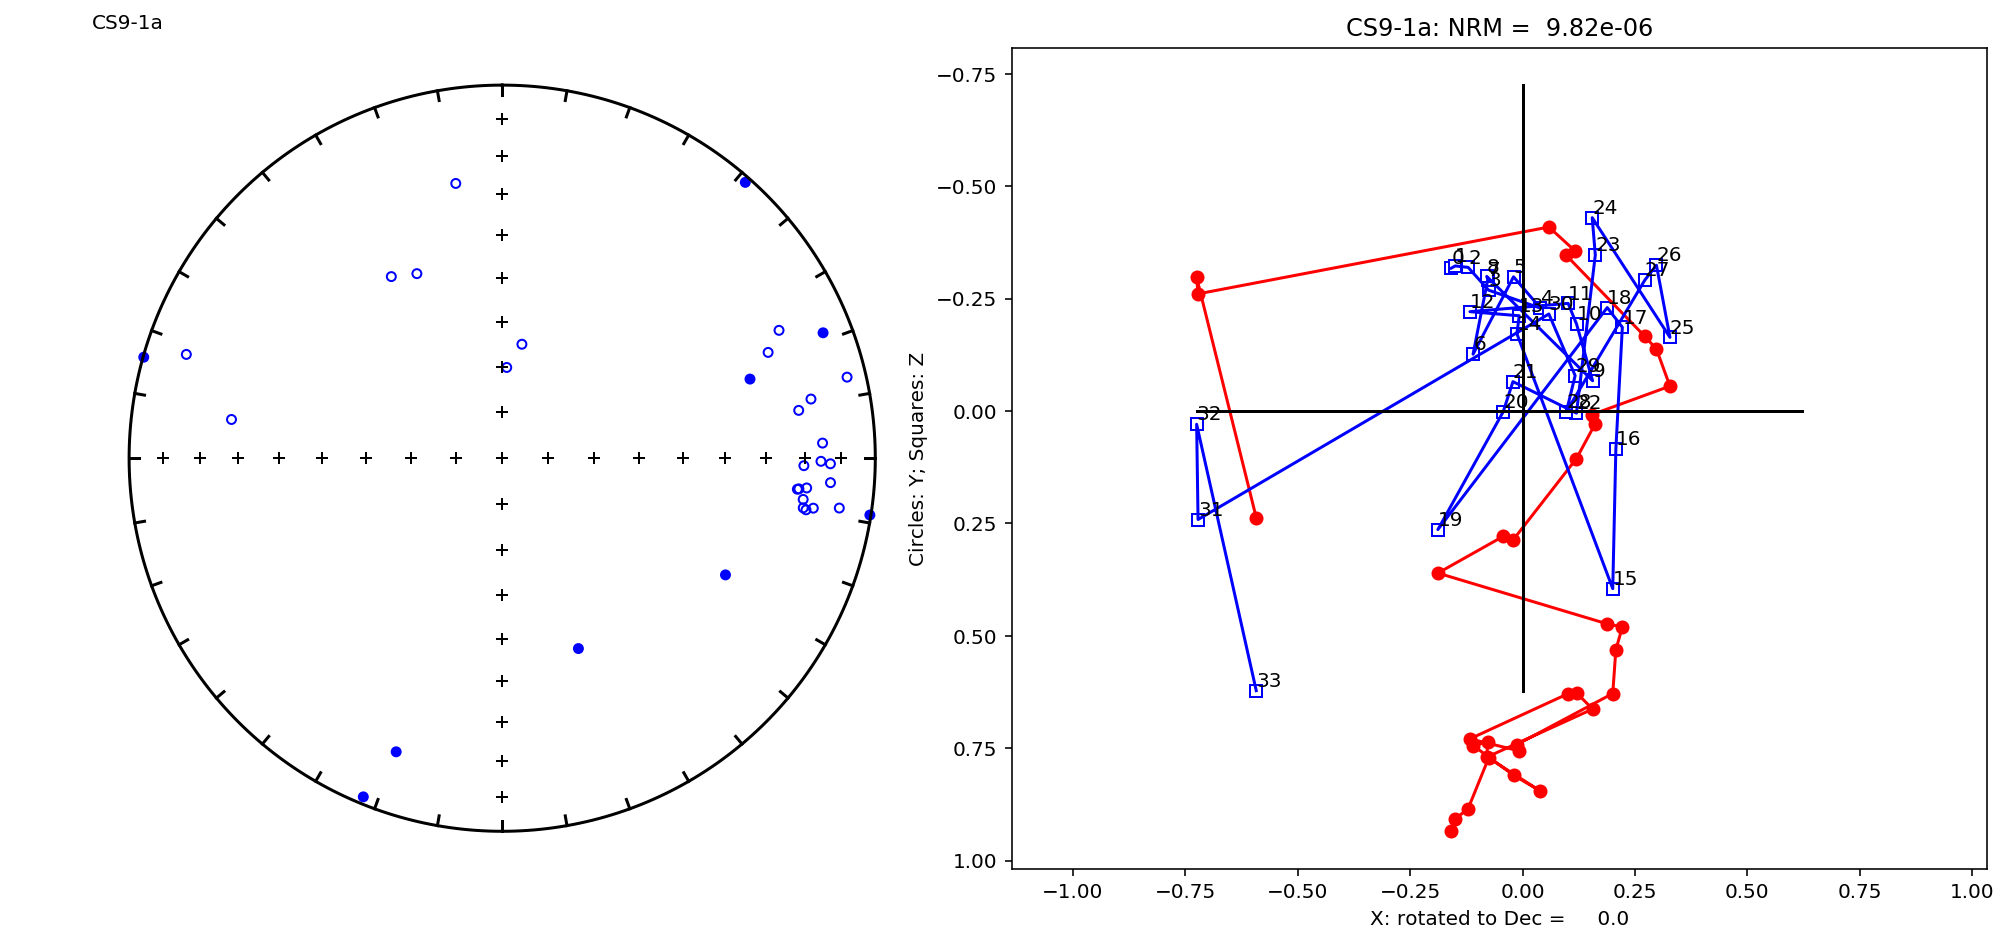

In [150]:
ZED={'eqarea':1,'zijd':2, 'demag':3}# make datablock
angle=0
units='emu'
fig=plt.figure(1, (14,6)) # make a figure
fig.add_subplot(121)
plot_eq(CS9_1a_OPRM_file[['dec','inc']].values.tolist(), 'CS9-1a')
fig.add_subplot(122)
plot_zij(CS9_1a_OPRM_file[['step','dec','inc','Ms','blank','quality']].values.tolist(),angle,'CS9-1a',units)